In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

np.random.seed(123)
az.style.use("arviz-doc")

## Exercise 1
***

*Using the howell dataset (available at https://github.com/aloctavodia/BAP3), create a linear model of the weight (x) against the height (y). Exclude subjects that are younger than 18. Explain the results.*



In [2]:
howell = pd.read_csv("../code/data/howell.csv", delimiter=";")
howell_age_18 =  howell[howell["age"] > 18]
howell_age_18.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

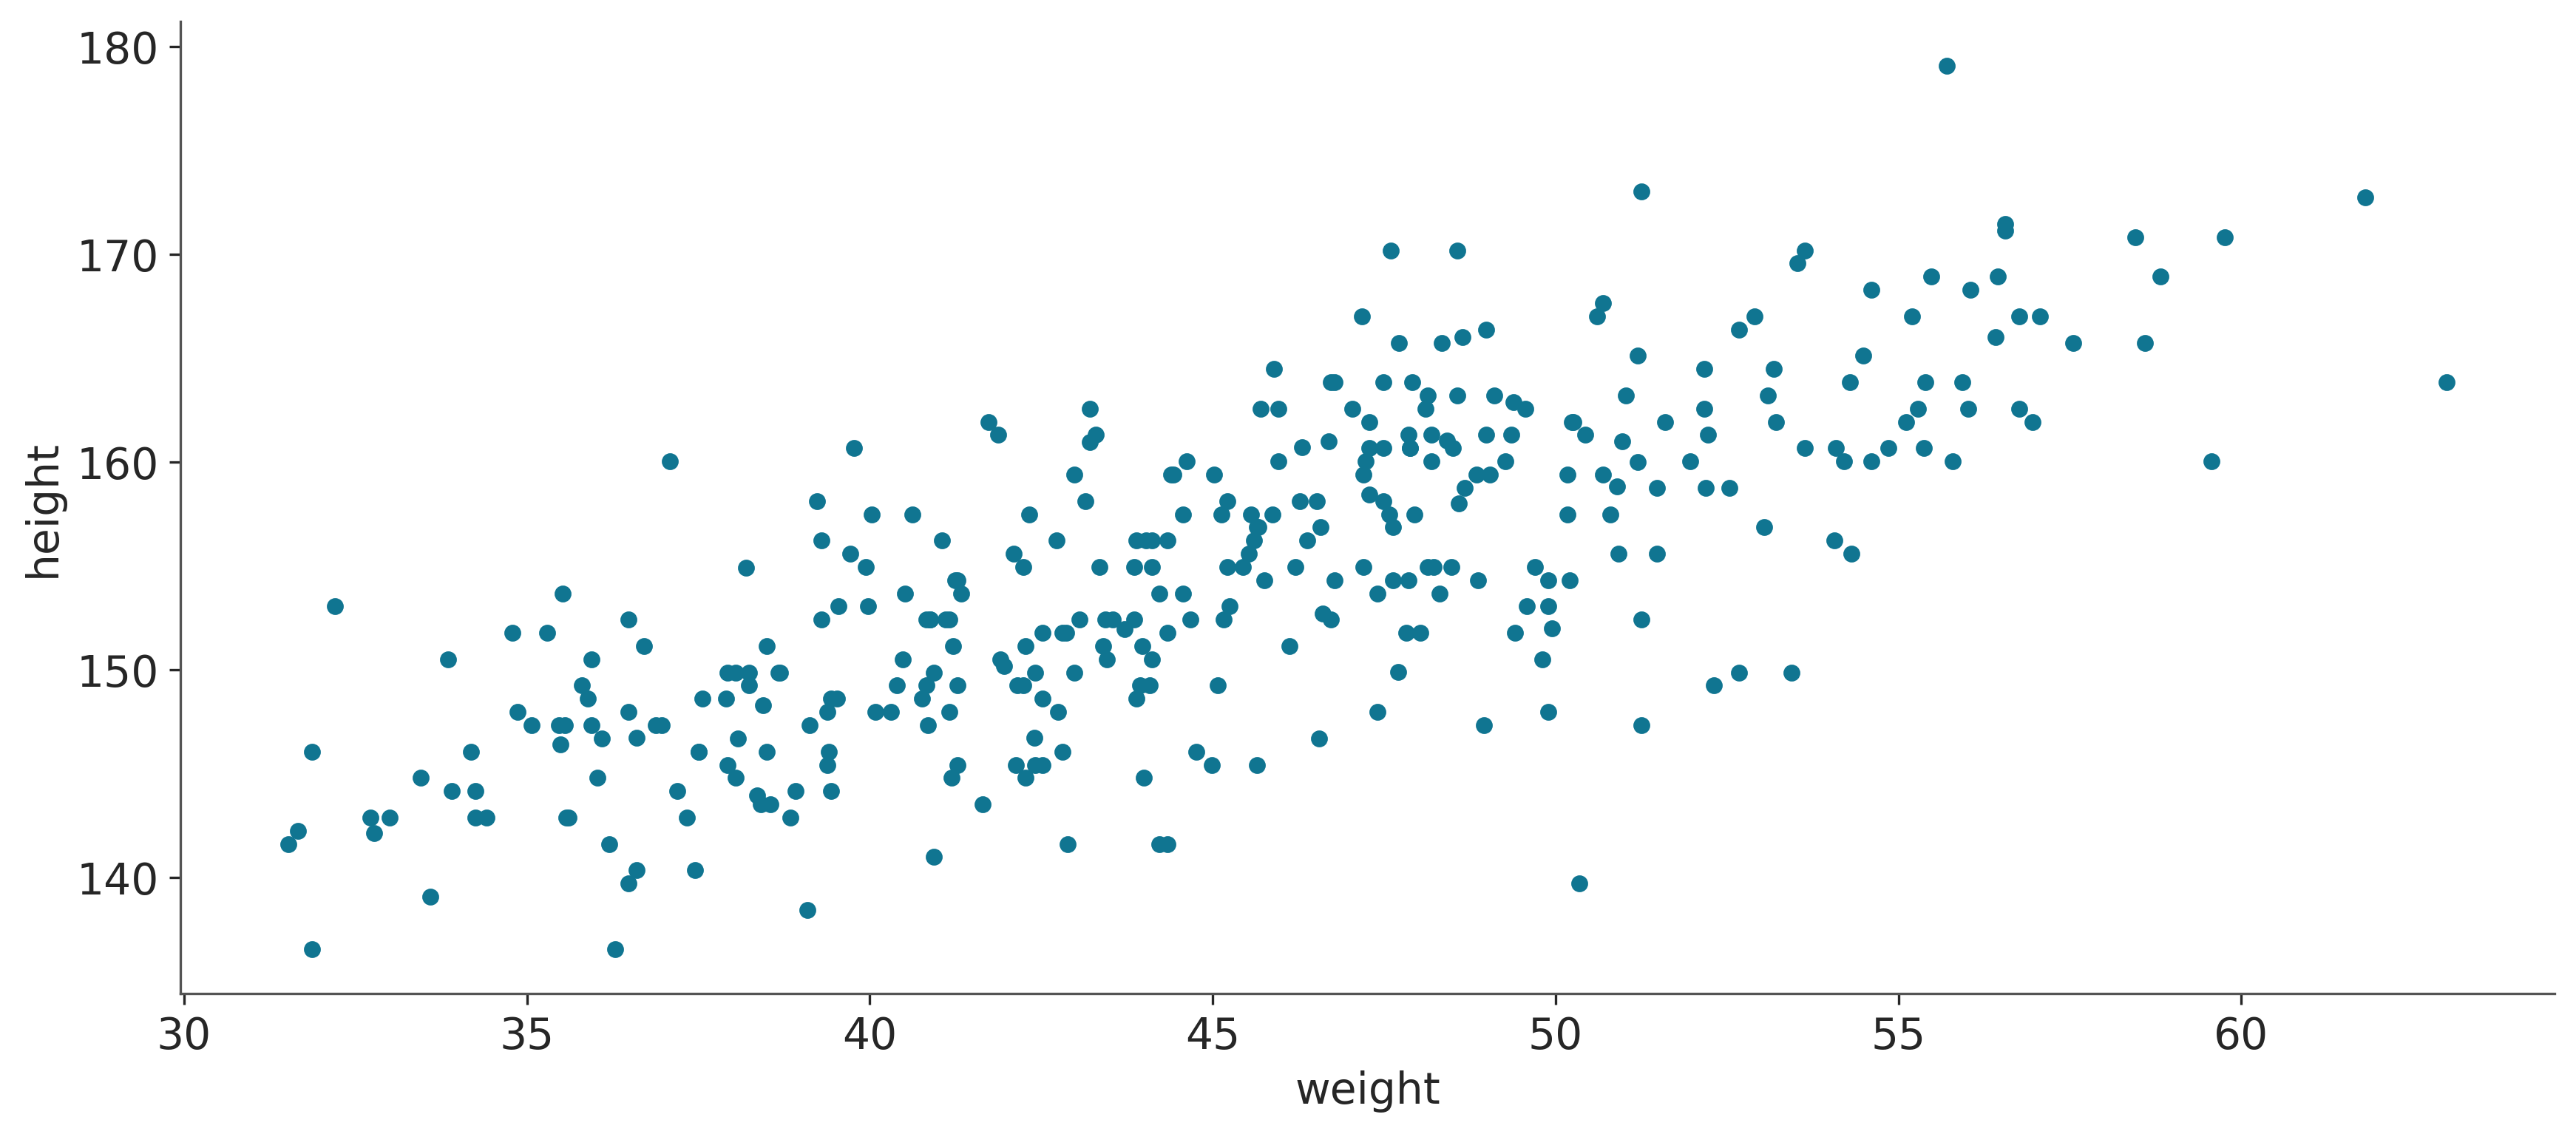

In [3]:
howell_age_18.plot(kind="scatter", x="weight", y="height");

When looking at the plot above this is with consistent our expectations. As weight increases, height increases as well. From visual inspection, it looks like a linear fit with some noise is best. In this case we will assume constant variance. Let's create a model:

In [4]:
mean_weight_age_18 = howell_age_18["weight"].mean()
howell_age_18.loc[:, "weight_centered"] = howell_age_18["weight"] - mean_weight_age_18


/tmp/ipykernel_13895/3508535169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  howell_age_18.loc[:, "weight_centered"] = howell_age_18["weight"] - mean_weight_age_18


In [5]:
with pm.Model() as over_18_heights:
    weight_shared = pm.MutableData("weight_shared", howell_age_18["weight_centered"])
    
    α = pm.Normal("α", howell_age_18["height"].mean(), sigma=1)
    β = pm.Normal("β", sigma=1)
    σ = pm.HalfNormal("σ", sigma=10)
    
    μ = pm.Deterministic("μ", α+β*weight_shared)
    
    height_pred = pm.Normal("height_pred", mu=μ, sigma=σ, observed = howell_age_18["height"], shape=weight_shared.shape[0])
    idata_over_18_heights = pm.sample()
    idata_over_18_heights = pm.sample_posterior_predictive(idata_over_18_heights, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height_pred]


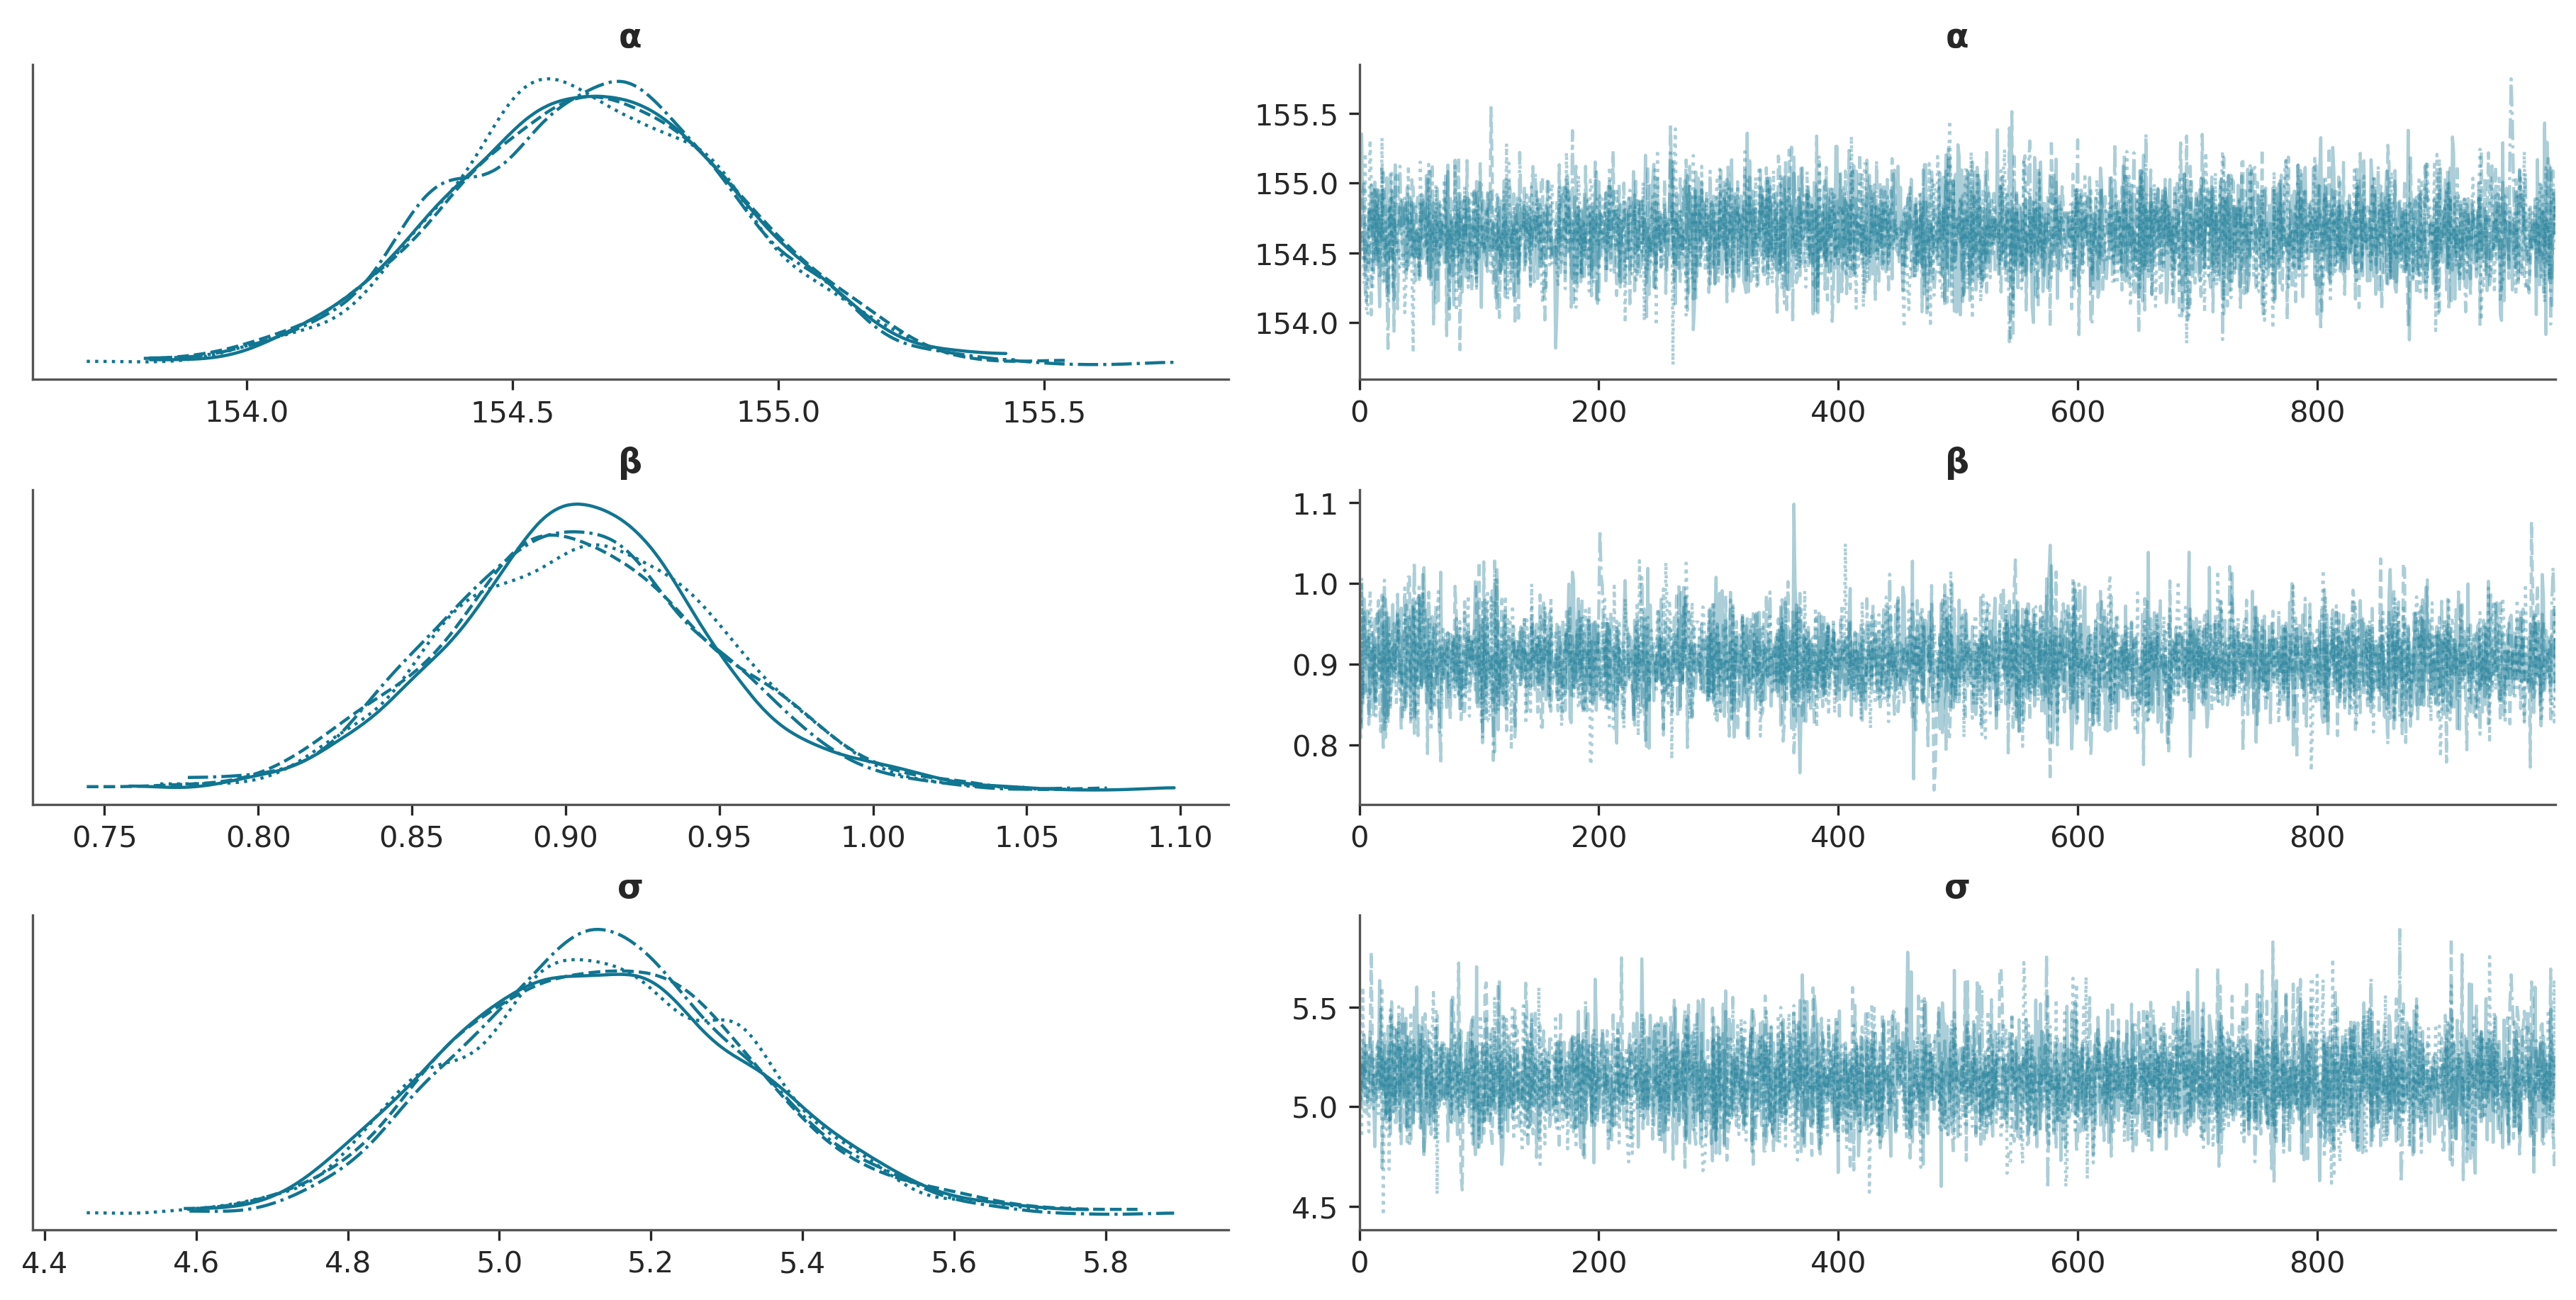

In [6]:

az.plot_trace(idata_over_18_heights, var_names = ["~μ"]);

Looking at the traceplot it looks like the inference engine was able to explore the posterior adequately. Let's plot the regression and the HDI.

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


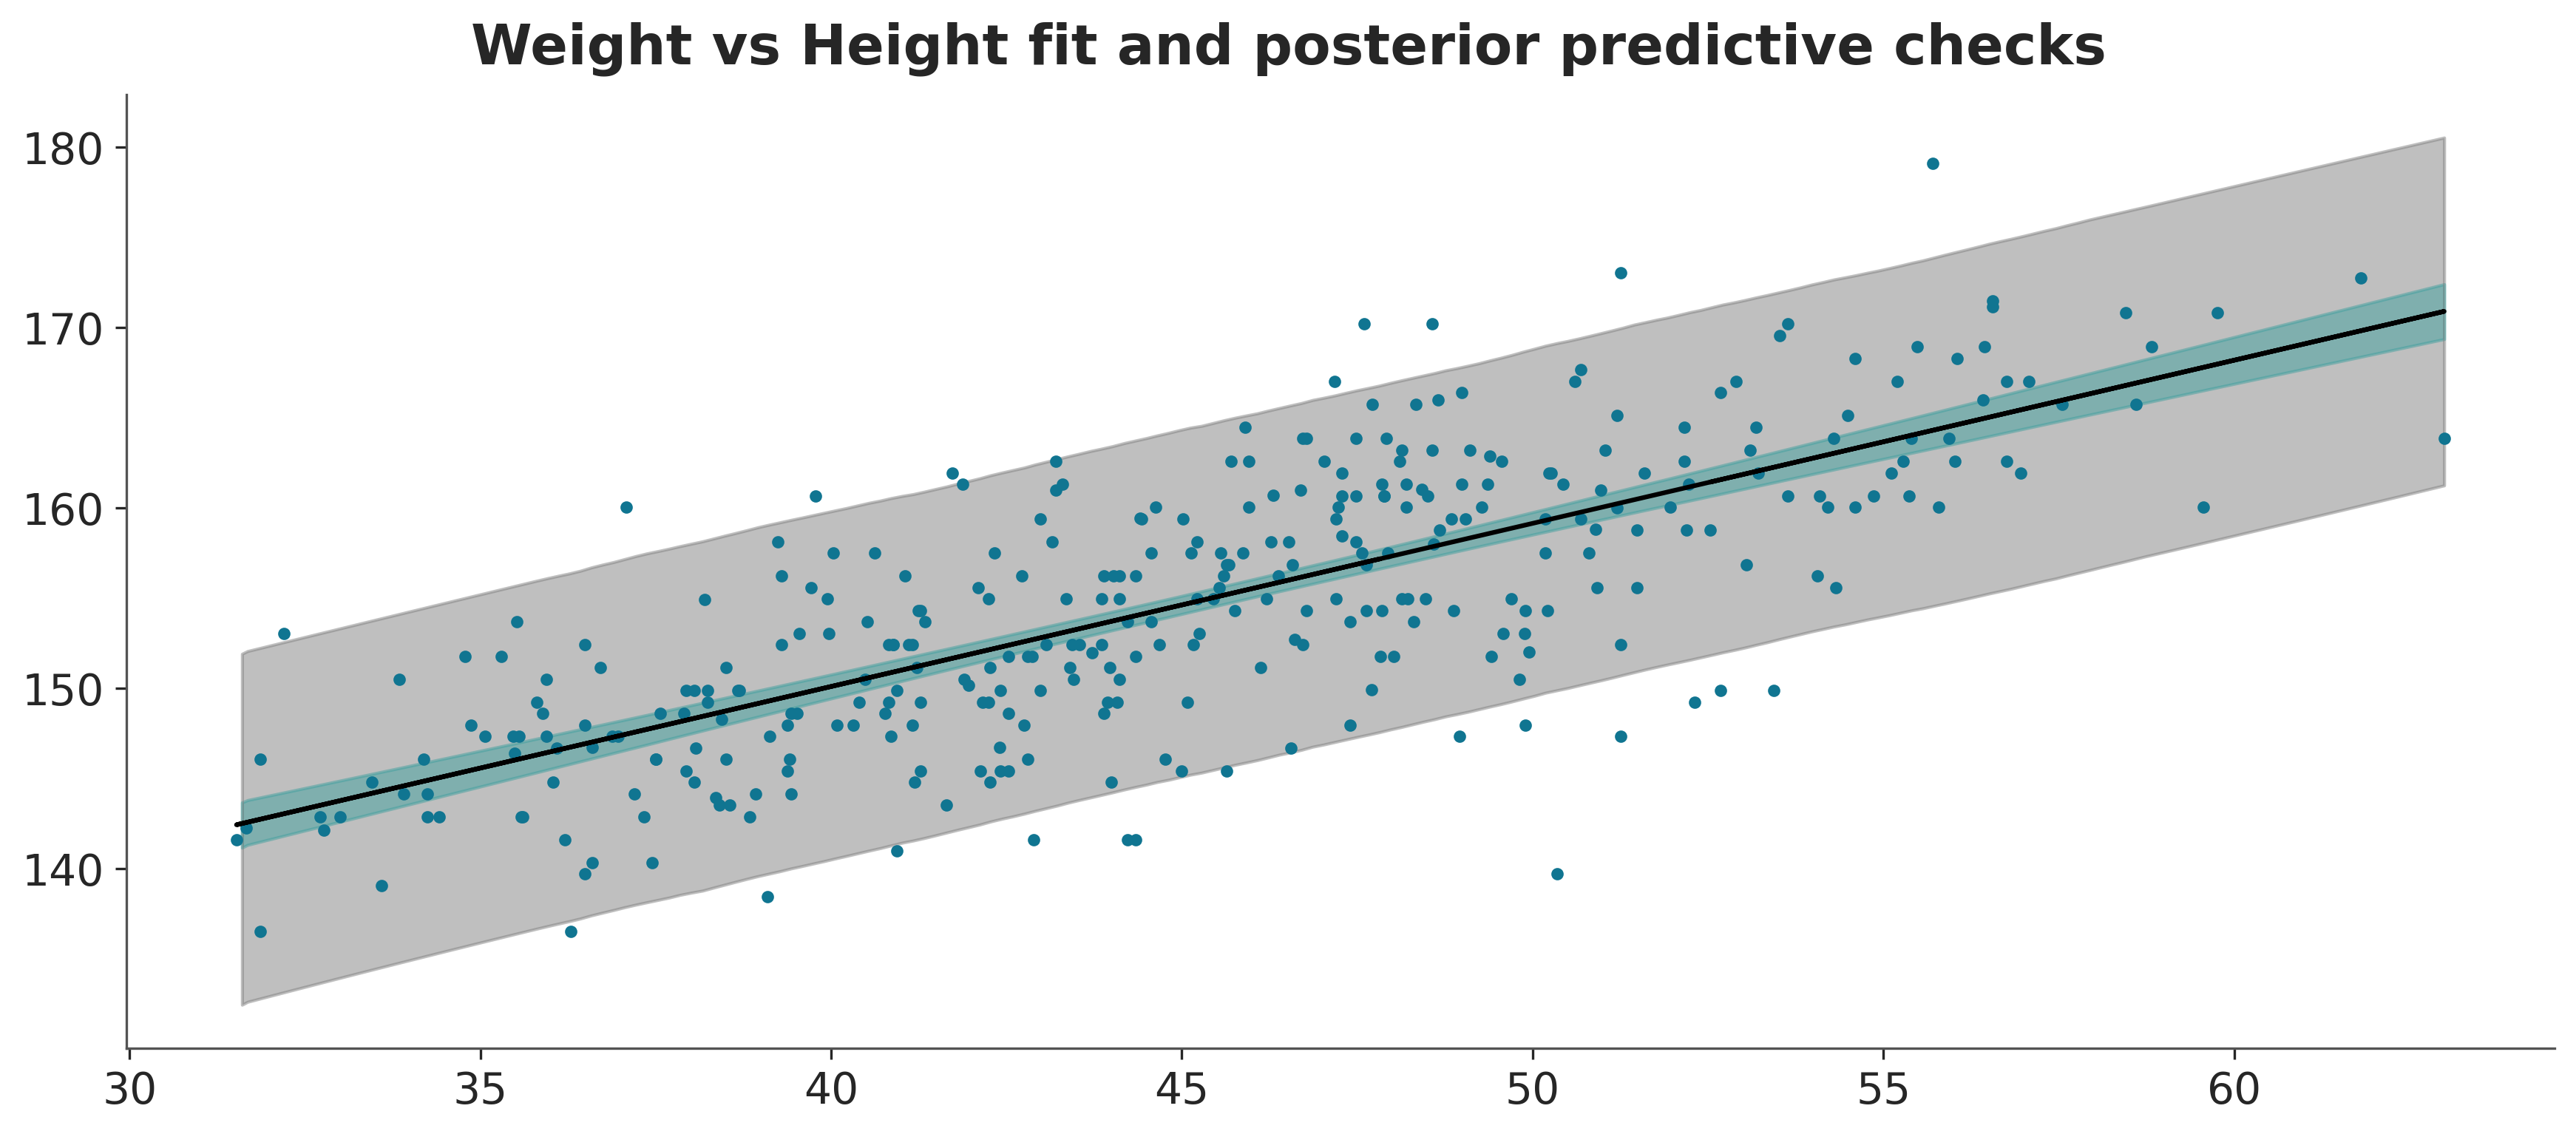

In [7]:
fig, ax = plt.subplots()

ax.plot(howell_age_18["weight"], howell_age_18["height"], "C0.")
posterior = az.extract(idata_over_18_heights, group="posterior")
pps = az.extract(idata_over_18_heights, group="posterior_predictive")["height_pred"]
μ_m = posterior["μ"].mean("sample")
ϵ_m = posterior["σ"].mean("sample")


ax.plot(howell_age_18["weight"], μ_m, c="k")
az.plot_hdi(howell_age_18["weight"], posterior["μ"].T)
az.plot_hdi(howell_age_18["weight"], pps.T, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

From visual inspection the average parameters of the fit look quite good, and the 94% interval of the posterior predictive checks covers most of the distribution. Overall, it looks like a linear fit is great for height vs weight for people over 18!

## Exercise 2
***

*For four subjects, we get the weights (45.73, 65.8, 54.2, 32.59), but not their heights. Using the model from the previous exercise, predict the height for each subject, together with their 50% and 94% HDIs. Tip: Use pm.MutableData.*

In [8]:
weights = (45.73, 65.8, 54.2, 32.59) - mean_weight_age_18

In [9]:
with over_18_heights:
    over_18_heights.set_data('weight_shared', weights)
    ppc = az.extract(pm.sample_posterior_predictive(idata_over_18_heights), group="posterior_predictive")

Sampling: [height_pred]


Now we can plot the posterior predictive checks for the new data points:

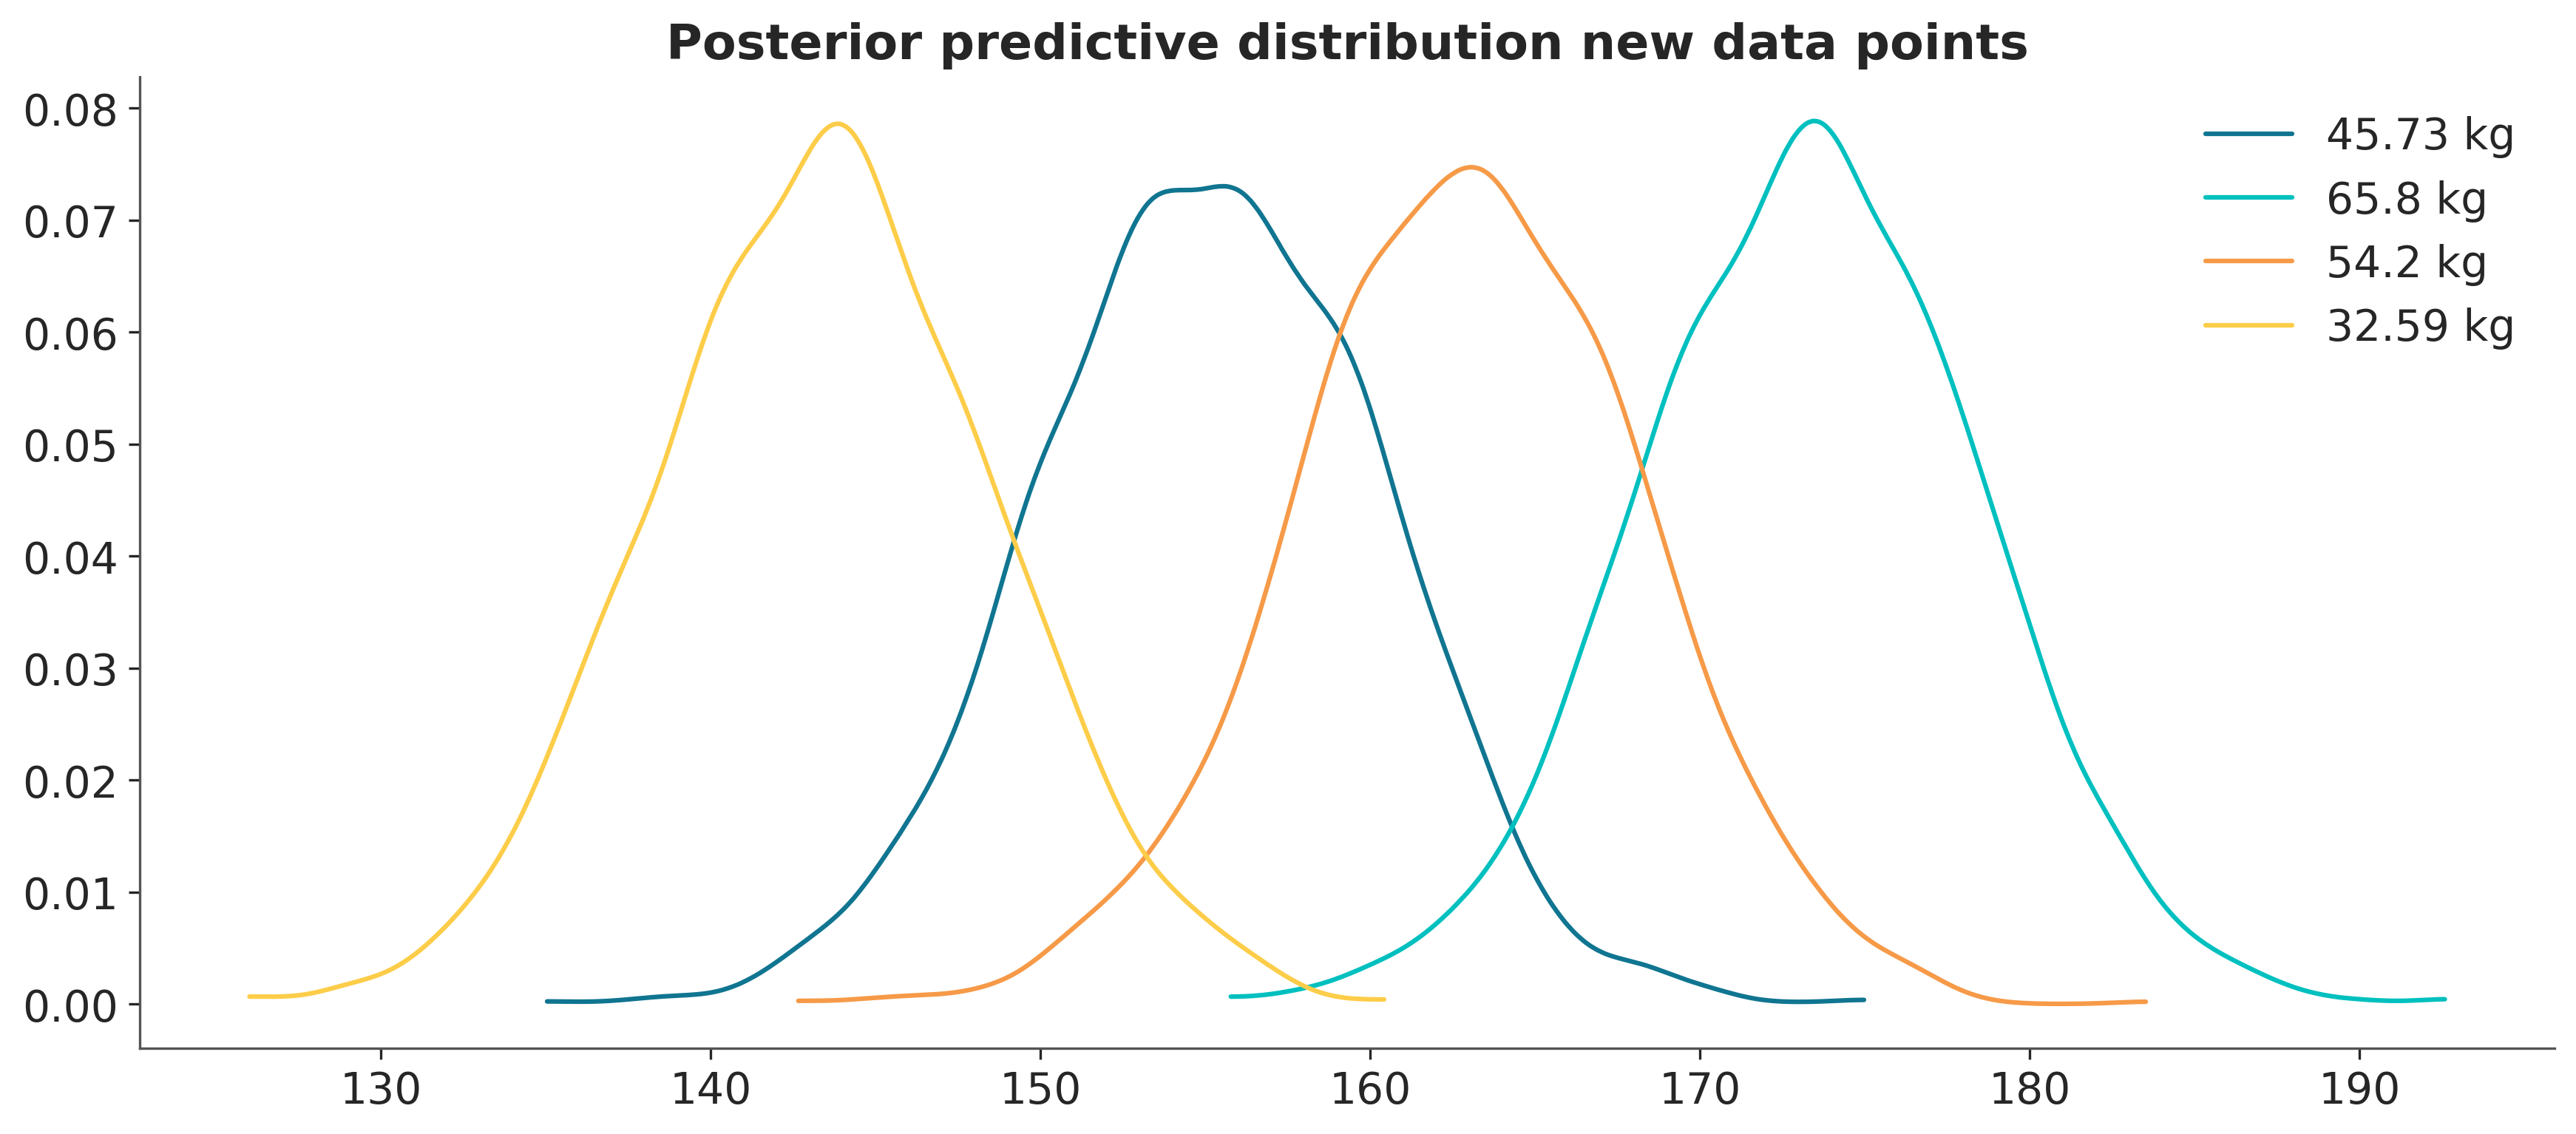

In [10]:
for idx, w in enumerate(weights):
    ppc_one = ppc["height_pred"].sel(height_pred_dim_2=idx).values
    ax = az.plot_kde(ppc_one, plot_kwargs={"color": f"C{idx}"}, label=f"{w + mean_weight_age_18} kg");
ax.legend()
ax.set_title(f"Posterior predictive distribution new data points");

## Exercise 3
***

*Repeat exercise 1, this time including those below 18 years old. Explain the results.*


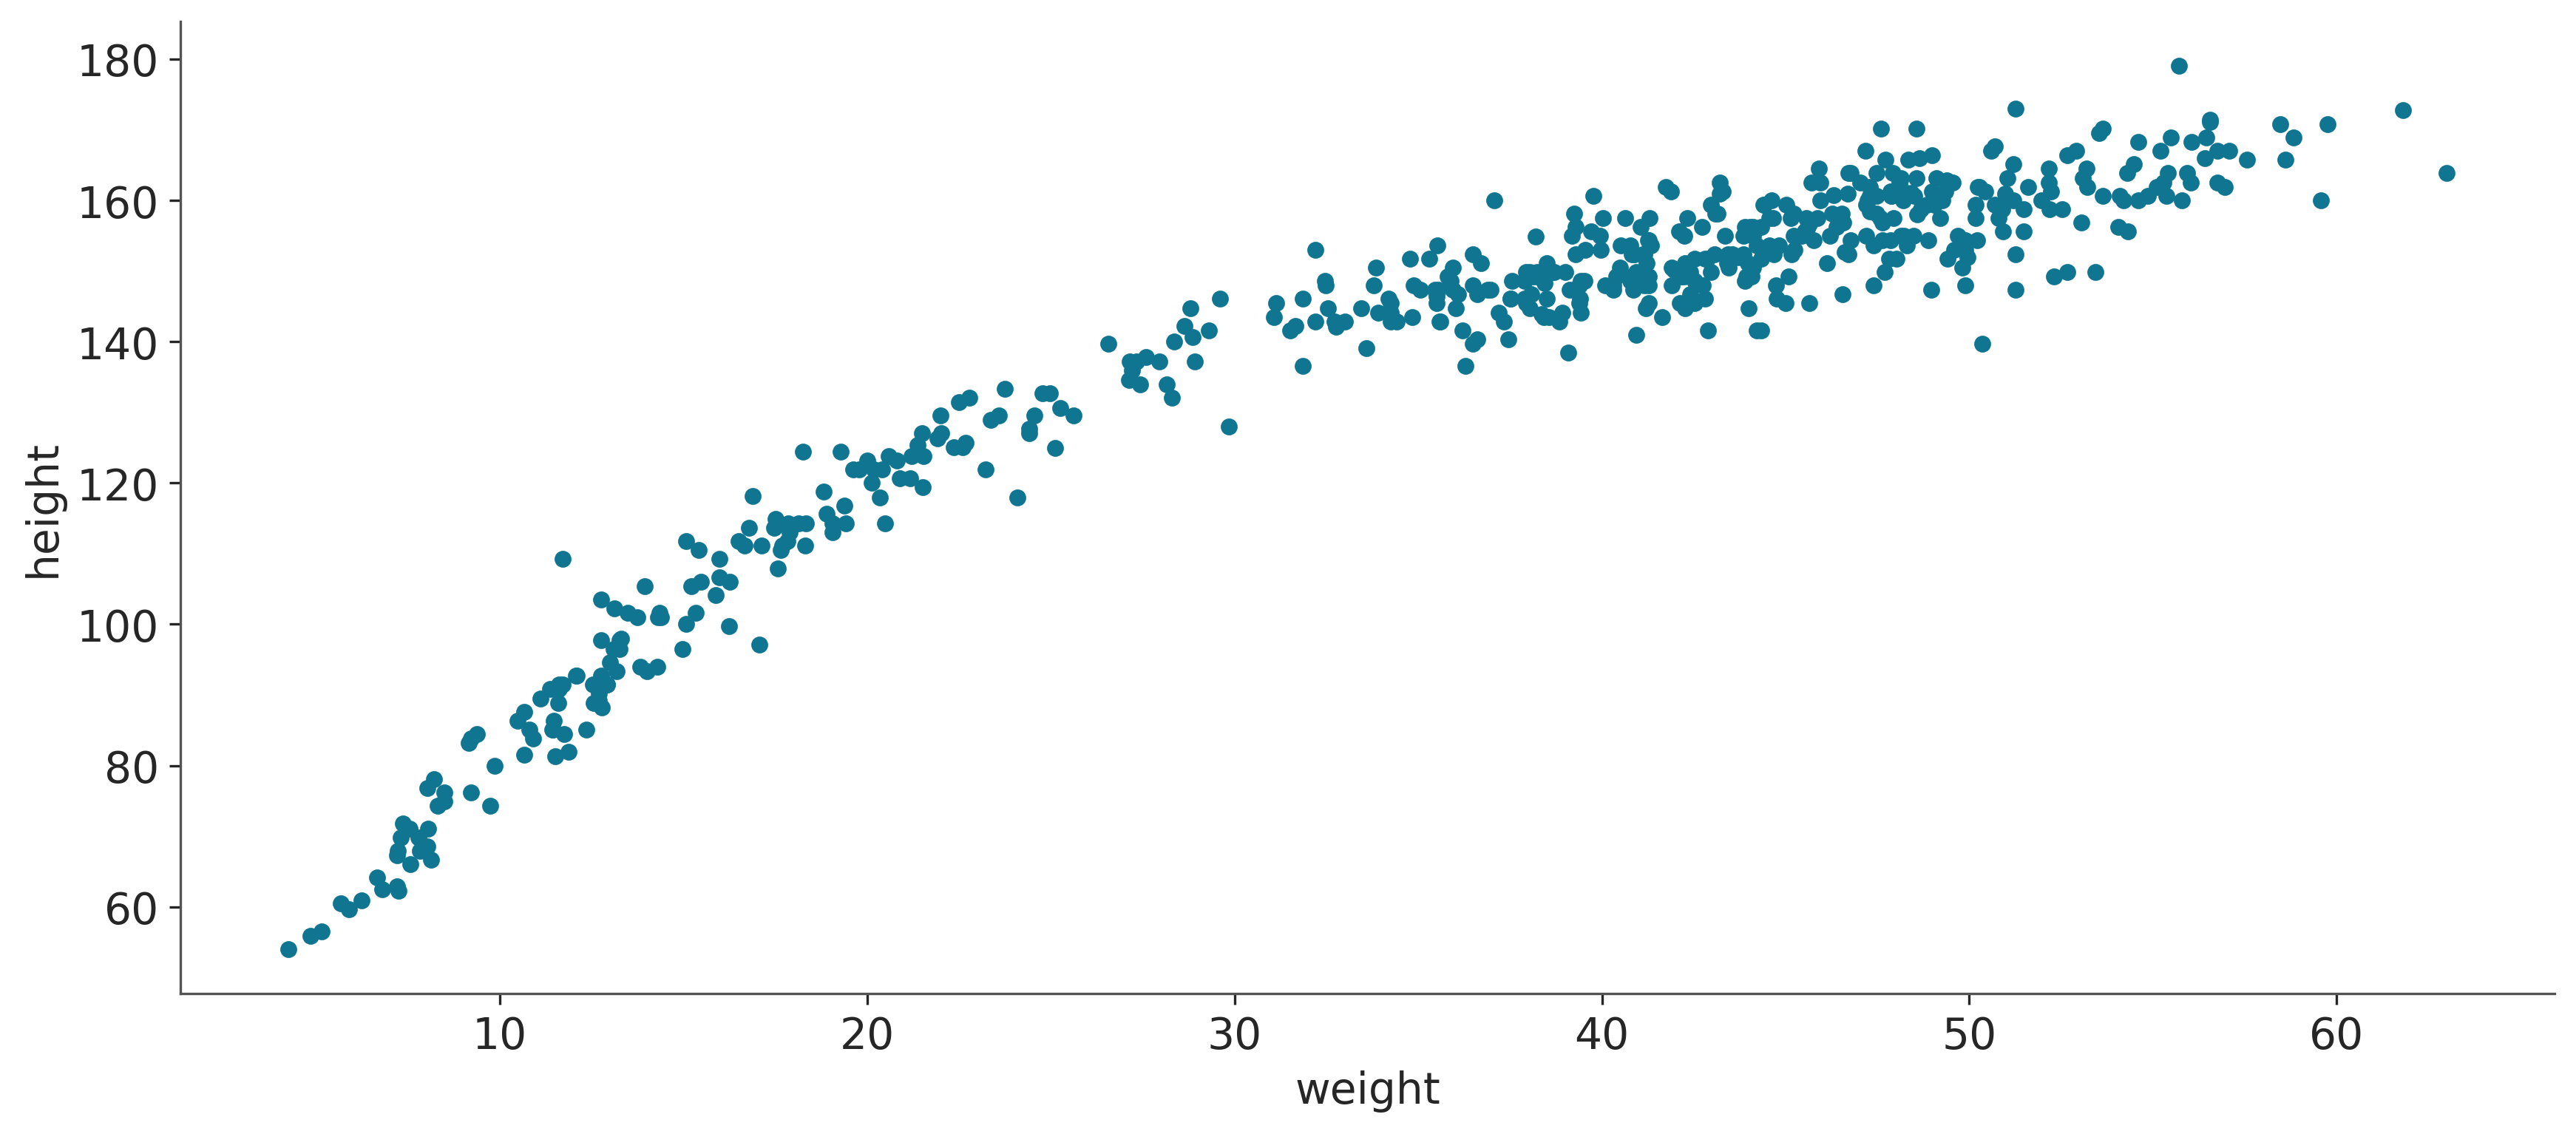

In [11]:
howell.plot(kind="scatter", x="weight", y="height");

In [12]:
mean_weight = howell["weight"].mean()
howell.loc[:, "weight_centered"] = howell["weight"] - mean_weight

In [13]:
with pm.Model() as heights:
    α = pm.Normal("α", howell["height"].mean(), sigma=1)
    β = pm.Normal("β", sigma=1)
    σ = pm.HalfNormal("σ", sigma=10)
    
    μ = pm.Deterministic("μ", α+β*howell["weight"] )
    
    height_pred = pm.Normal("height_pred", mu=μ, sigma=σ, observed = howell["height"])
    idata_heights = pm.sample()
    idata_heights = pm.sample_posterior_predictive(idata_heights, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height_pred]


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


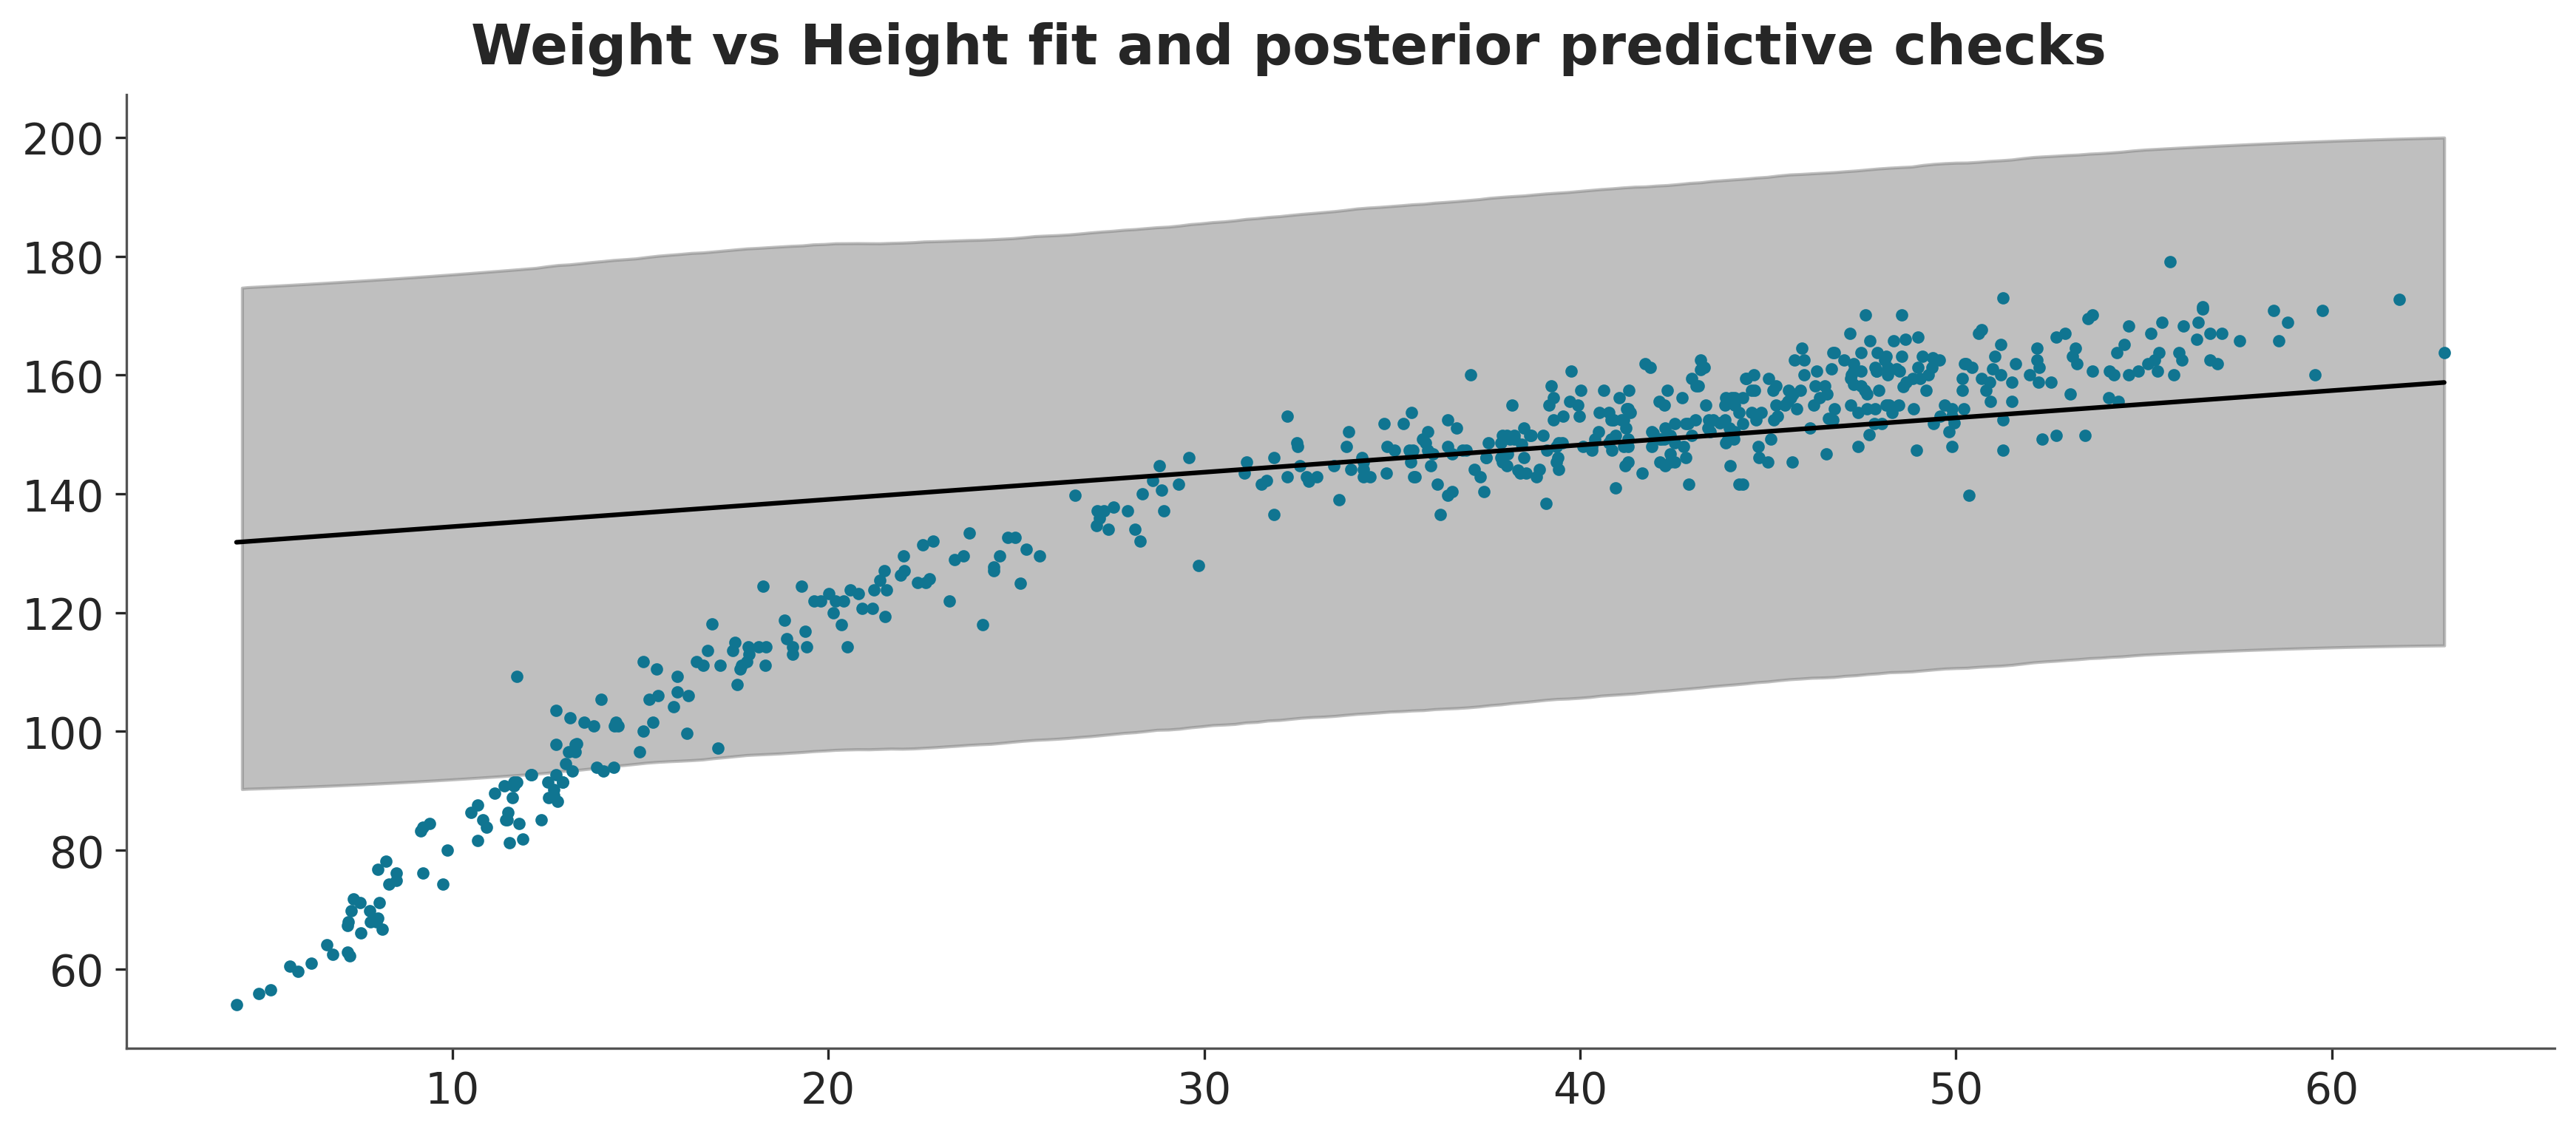

In [14]:
fig, ax = plt.subplots()

ax.plot(howell["weight"], howell["height"], "C0.")
posterior = az.extract(idata_heights, group="posterior")
pps = az.extract(idata_heights, group="posterior_predictive")["height_pred"]
μ_m = posterior["μ"].mean("sample")
order = np.argsort(howell["weight"].values)
ax.plot(howell["weight"][order], μ_m[order], c="k")


az.plot_hdi(howell["weight"], pps.T, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

Our model made a very bad job at fitting the data. 

## Exercise 4
***

*It is known for many species that weight does not scale with height, but with the logarithm of the weight. Use this information to fit the howell data (including subjects from all ages).*

For this model we are also going to assume a variable variance. Let's create the model:

In [15]:
with pm.Model() as heights:
    weight_shared = pm.MutableData("weight_shared", howell["weight"])

    α = pm.Normal("α", 0, sigma=20)
    β = pm.Normal("β", sigma=10)
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)
    
    μ = pm.Deterministic("μ", α+β*pm.math.log(weight_shared))
    σ = pm.Deterministic("σ", γ+δ*weight_shared)
    
    height_pred = pm.Normal("height_pred", mu=μ, sigma=σ, observed = howell["height"], shape=weight_shared.shape[0])
    idata_heights = pm.sample()
    idata_heights = pm.sample_posterior_predictive(idata_heights, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, γ, δ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [height_pred]


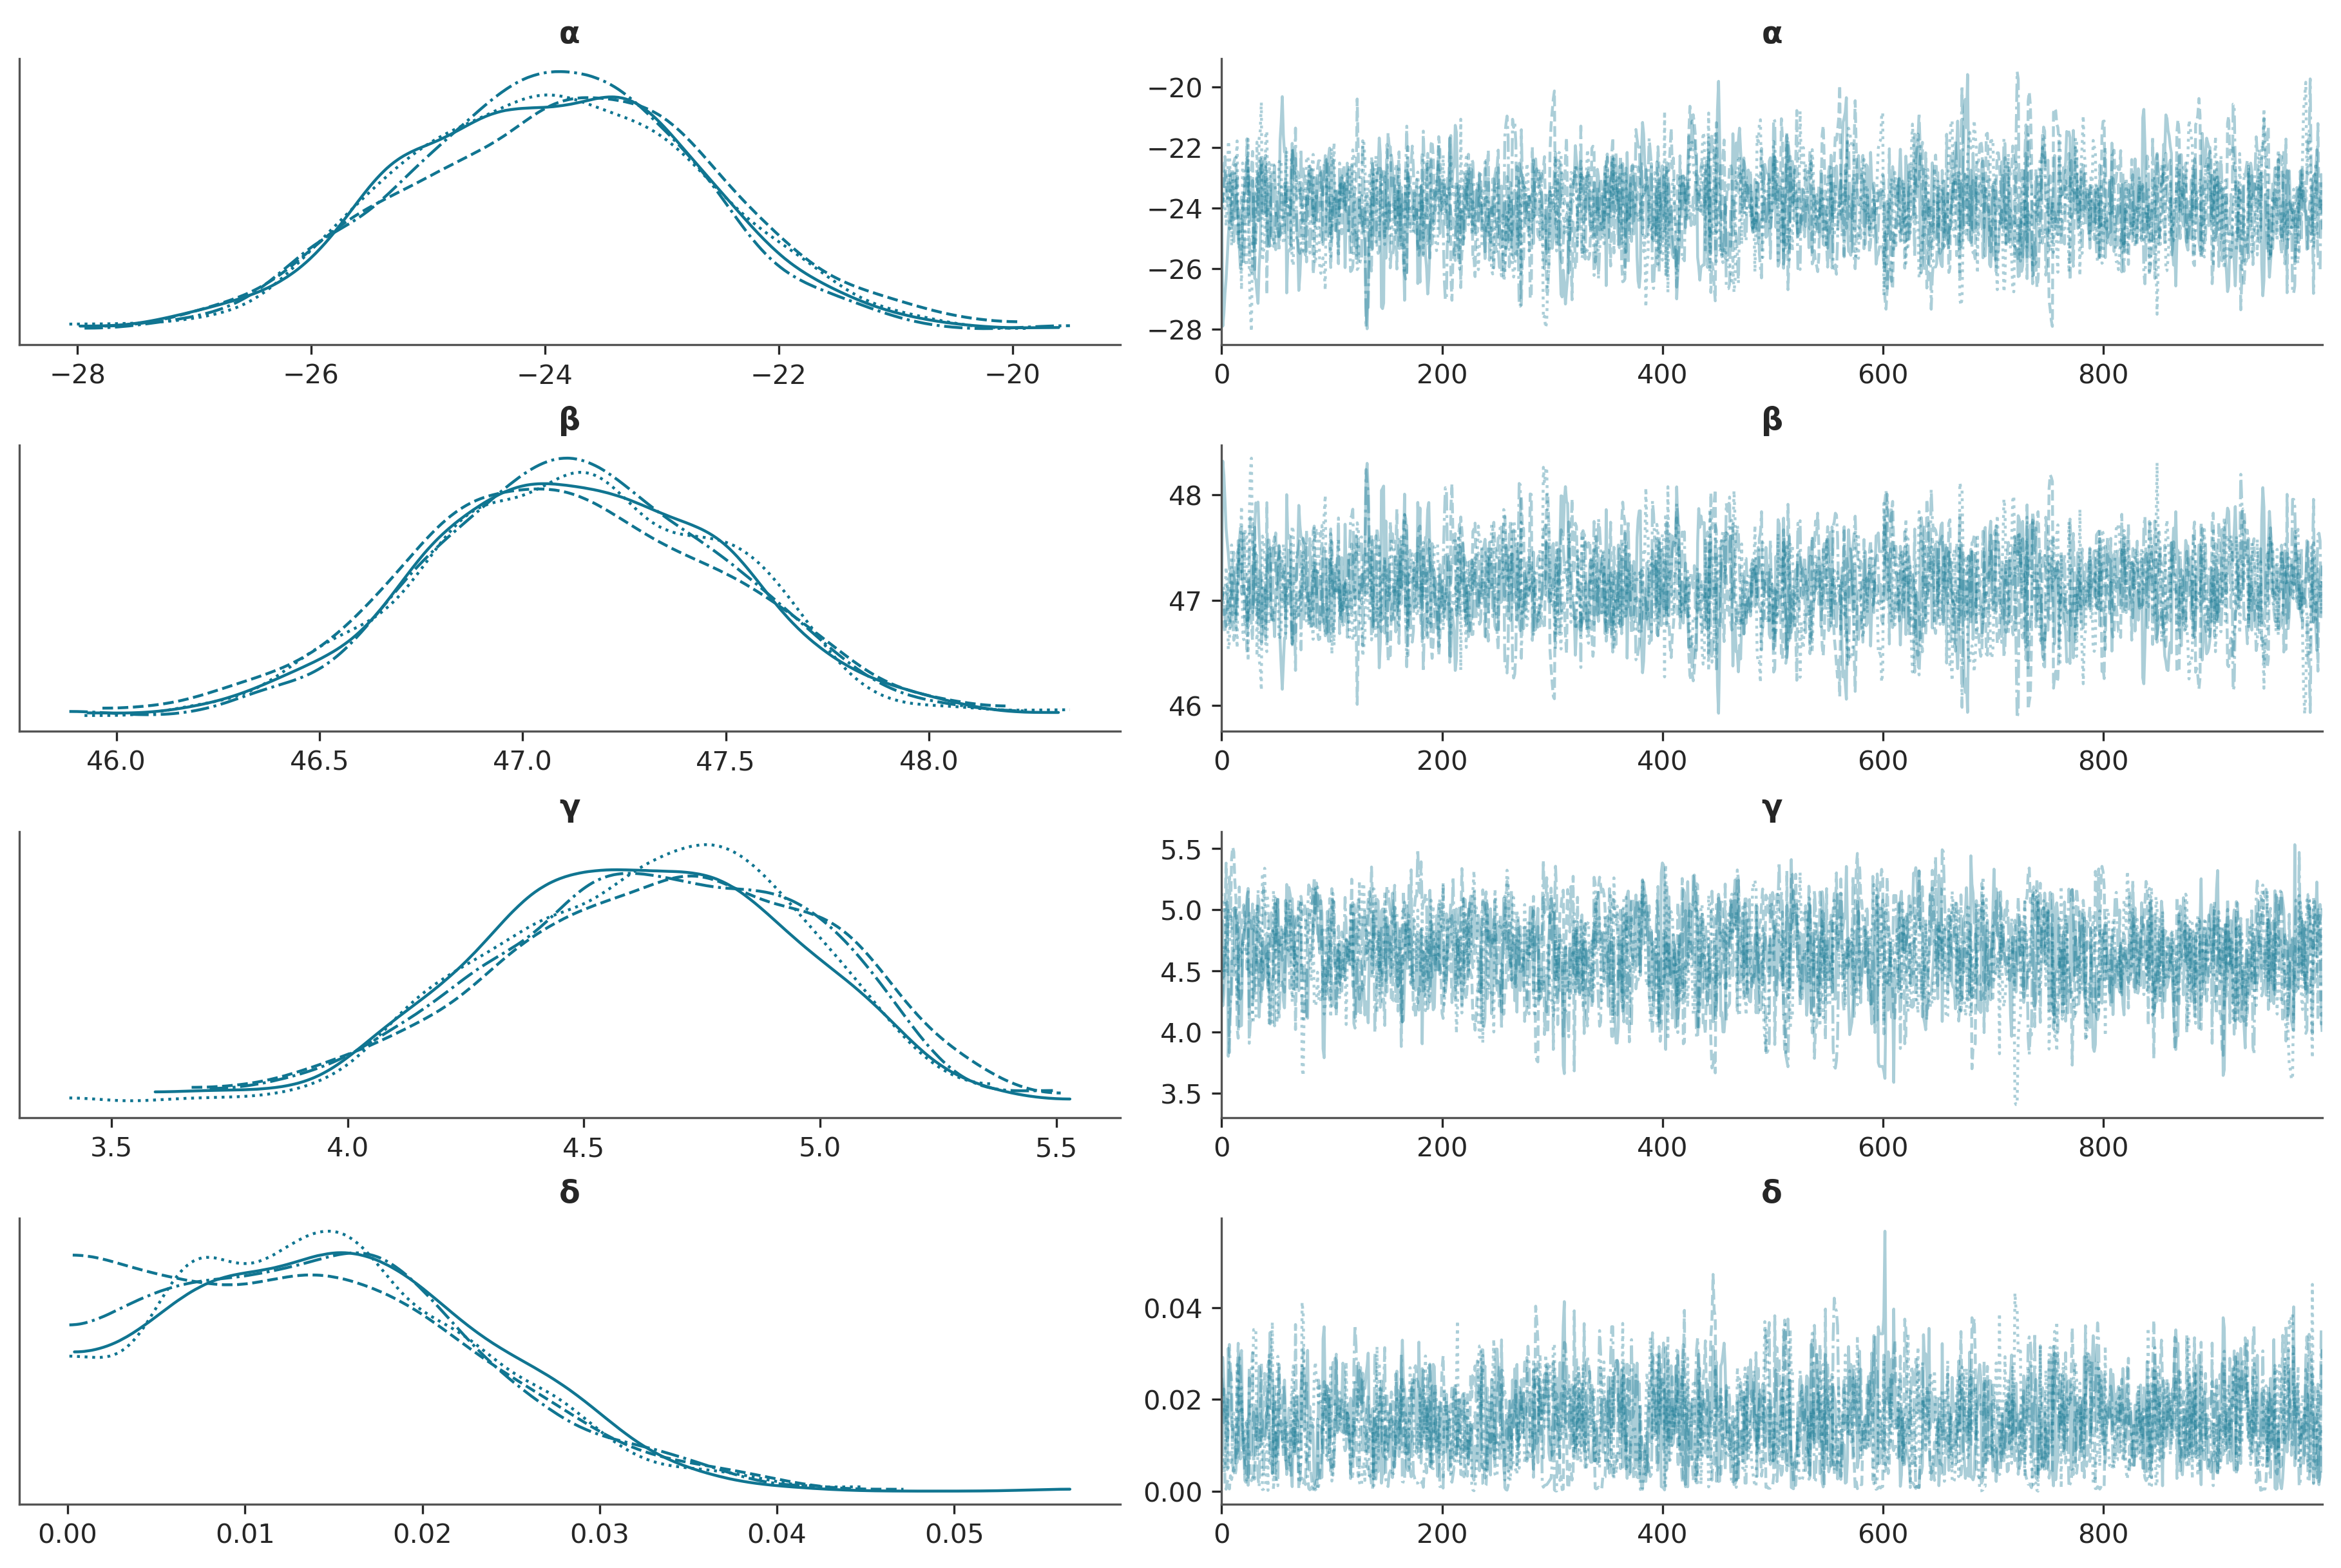

In [16]:
az.plot_trace(idata_heights, var_names=["~μ", "~σ"]);

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


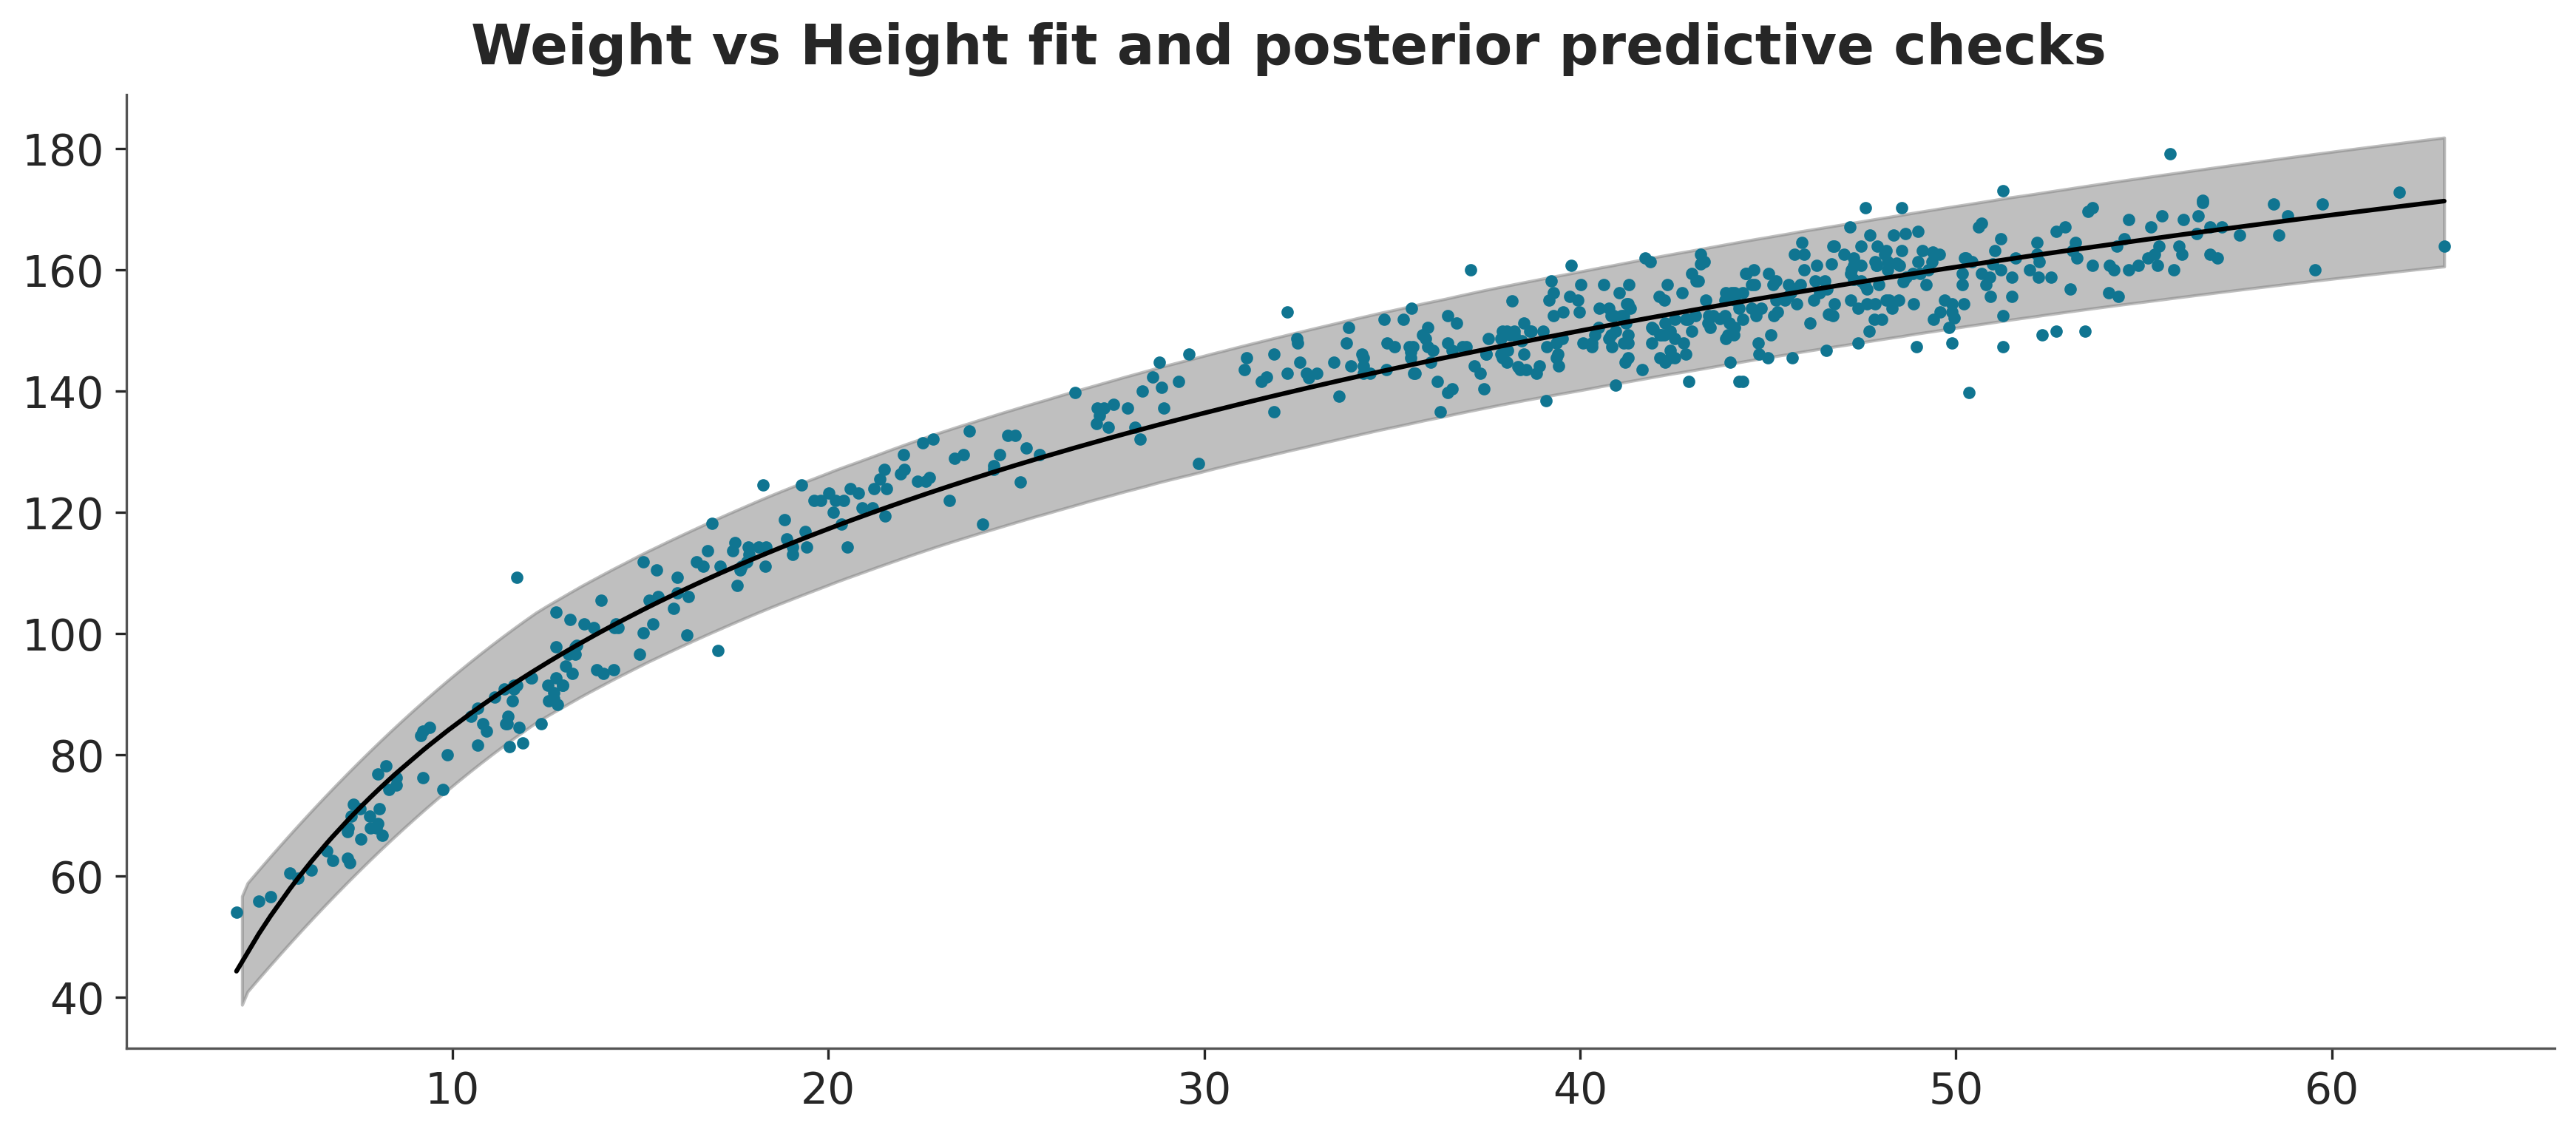

In [17]:
fig, ax = plt.subplots()

ax.plot(howell["weight"], howell["height"], "C0.")
posterior = az.extract(idata_heights, group="posterior")
pps = az.extract(idata_heights, group="posterior_predictive")["height_pred"]
μ_m = posterior["μ"].mean("sample")
order = np.argsort(howell["weight"].values)
ax.plot(howell["weight"][order], μ_m[order], c="k")


az.plot_hdi(howell["weight"], pps.T, color="gray")
fig.suptitle("Weight vs Height fit and posterior predictive checks");

Let's also plot the noise as a function of weight:

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


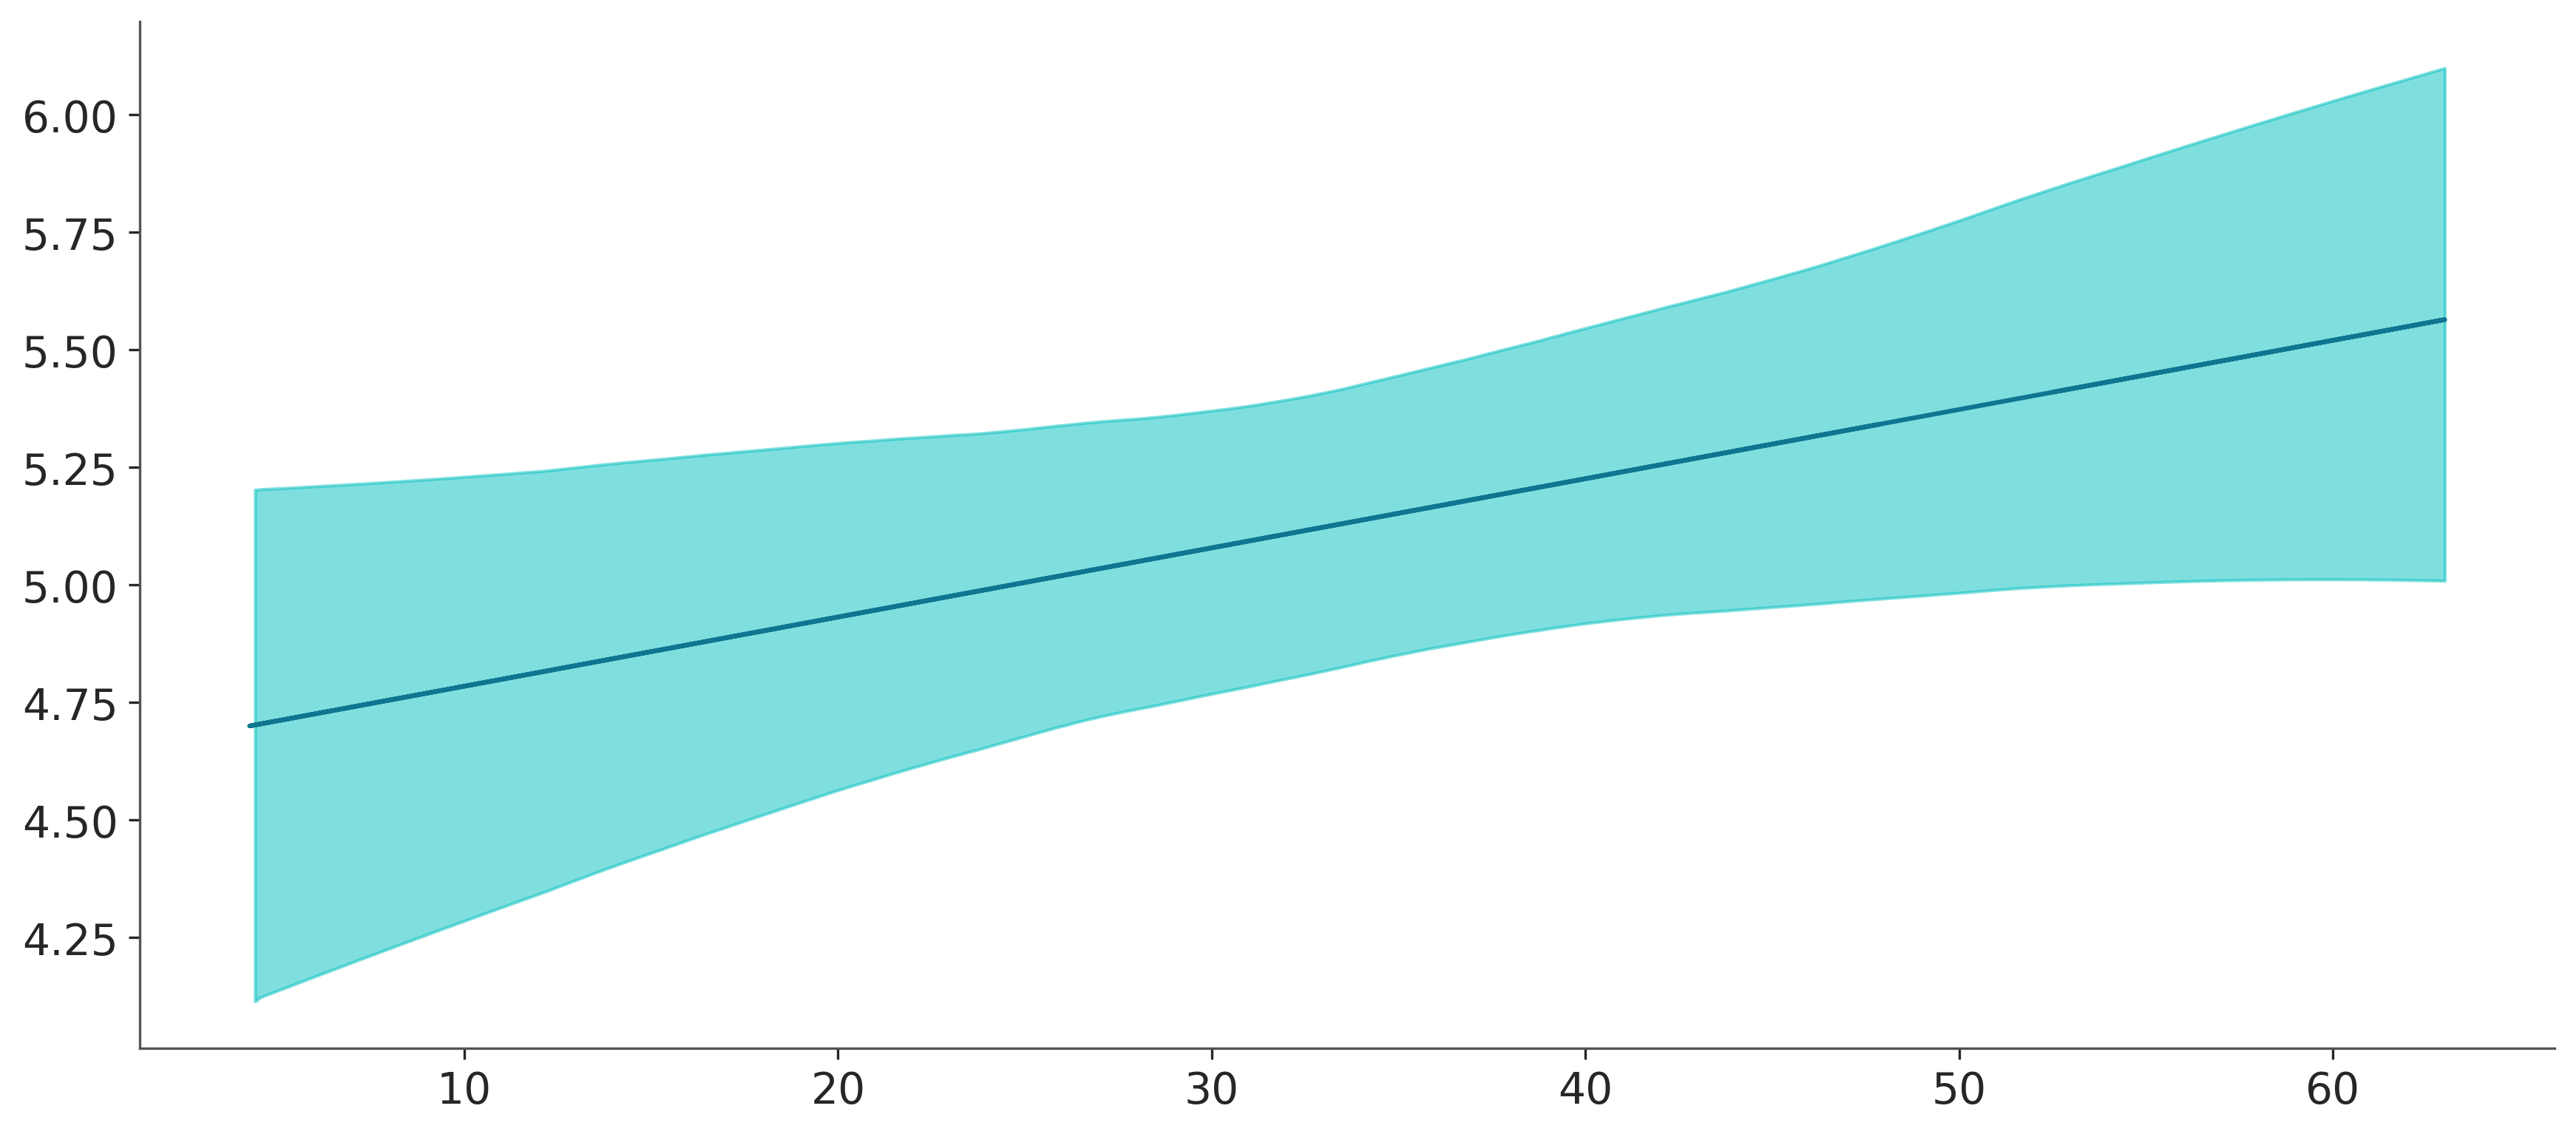

In [18]:
fig, ax = plt.subplots()
ax.plot(howell["weight"], posterior["σ"].mean("sample"))
az.plot_hdi(howell["weight"], posterior["σ"].T);

We can see that in lower weight ranges there tends to be less variability in height than for bigger weight ranges (i.e when people are older). This makes sense intuitively, as humans start out roughly the same in their earlier years, and tend to become more different in physical dimensions as they grow older in age and weight.

## Exercise 5
***

*See in the code accompanying the book the `model_t2` (and the data associated with it). Experiment with priors for $\nu$, like the non-shifted Exponential and Gamma priors (they are commented in the code). Plot the prior distribution, to ensure that you understand them. An easy way to do this is to just comment the likelihood in the model and check the trace plot. A more efficient way though is to use the `pm.sample_prior_predictive()` function instead of `pm.sample()`.*

In [19]:
ans = pd.read_csv('../code/data/anscombe.csv')

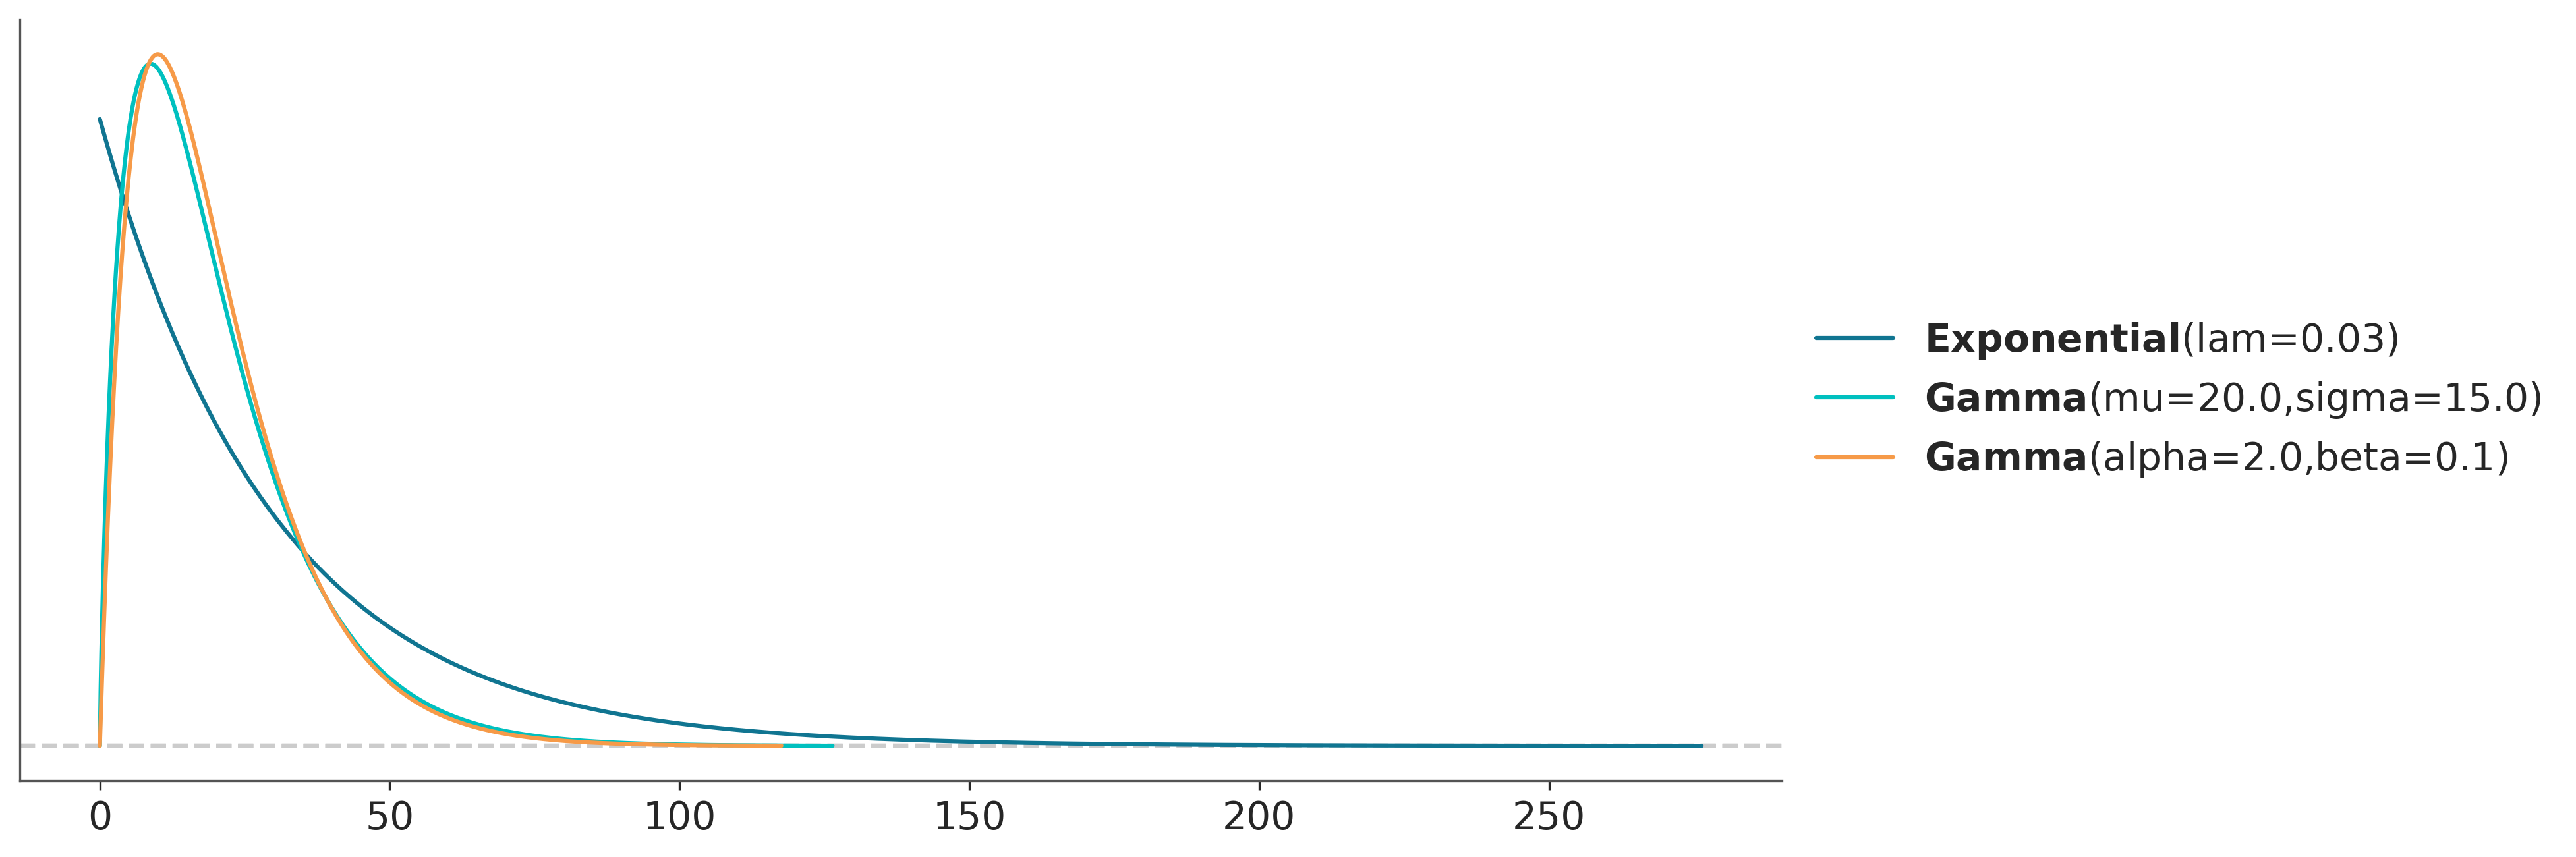

In [20]:
pz.Exponential(1/30).plot_pdf()
pz.Gamma(mu=20, sigma=15).plot_pdf()
pz.Gamma(2, 0.1).plot_pdf();

In [21]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

In [22]:
with pm.Model() as model_t2_exp:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    σ = pm.HalfCauchy('σ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sigma=σ, nu=ν, observed=y_4)
    
    idata_t2_exp = pm.sample_prior_predictive()
    idata_t2_exp.extend(pm.sample())


Sampling: [y_pred, α, β, ν, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [23]:
with pm.Model() as model_t2_gamma:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    σ = pm.HalfCauchy('σ', 5)
    ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sigma=σ, nu=ν, observed=y_4)
    
    idata_t2_gamma = pm.sample_prior_predictive()
    idata_t2_gamma.extend(pm.sample())

Sampling: [y_pred, α, β, ν, σ]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


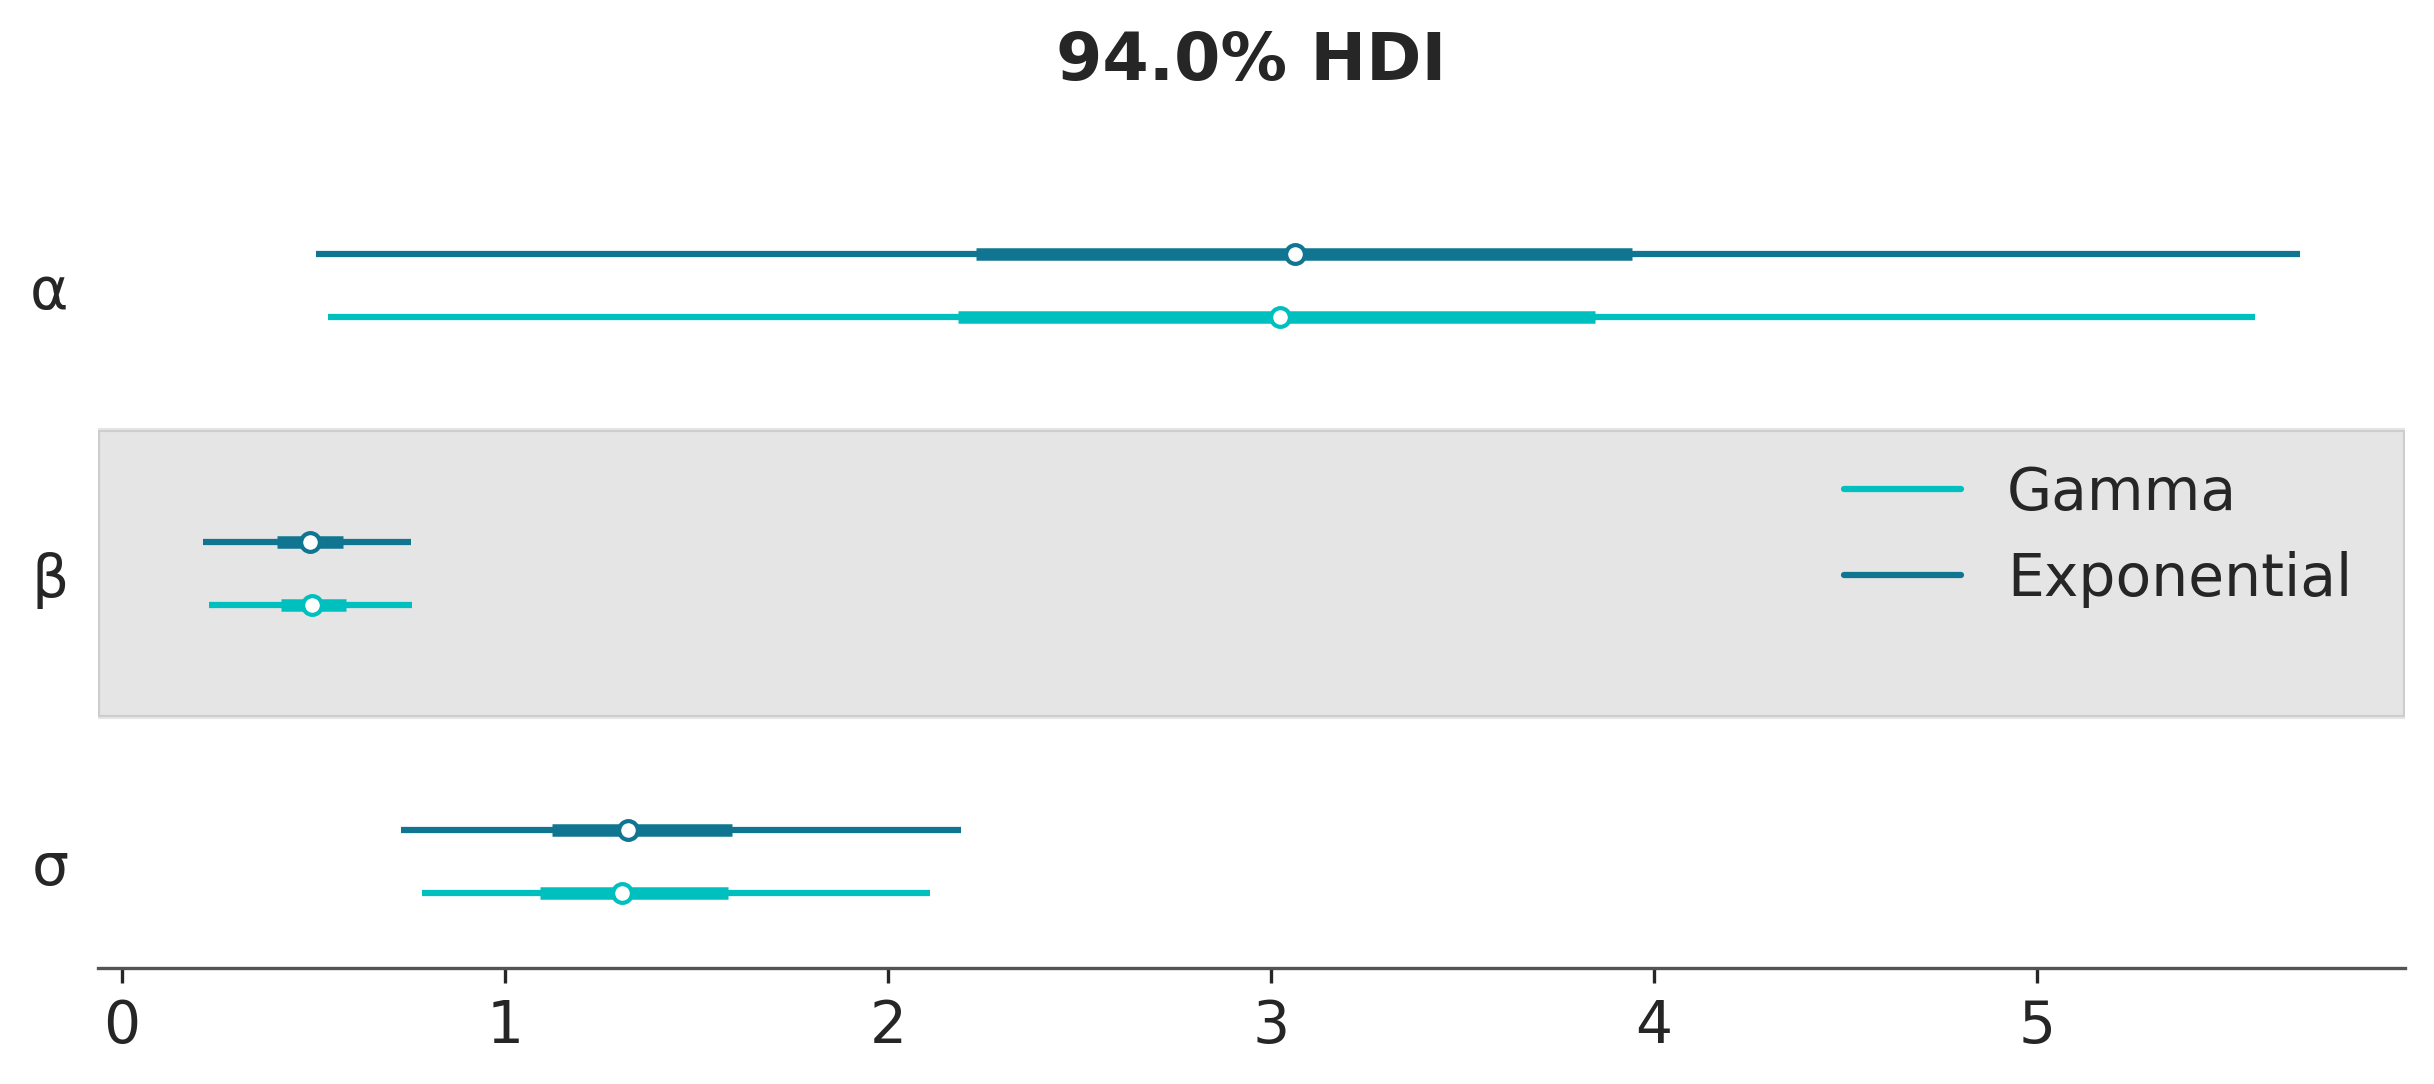

In [24]:
az.plot_forest([idata_t2_exp, idata_t2_gamma], model_names=["Exponential", "Gamma"], var_names=["~ν"], figsize=(8, 3.5), combined=True);

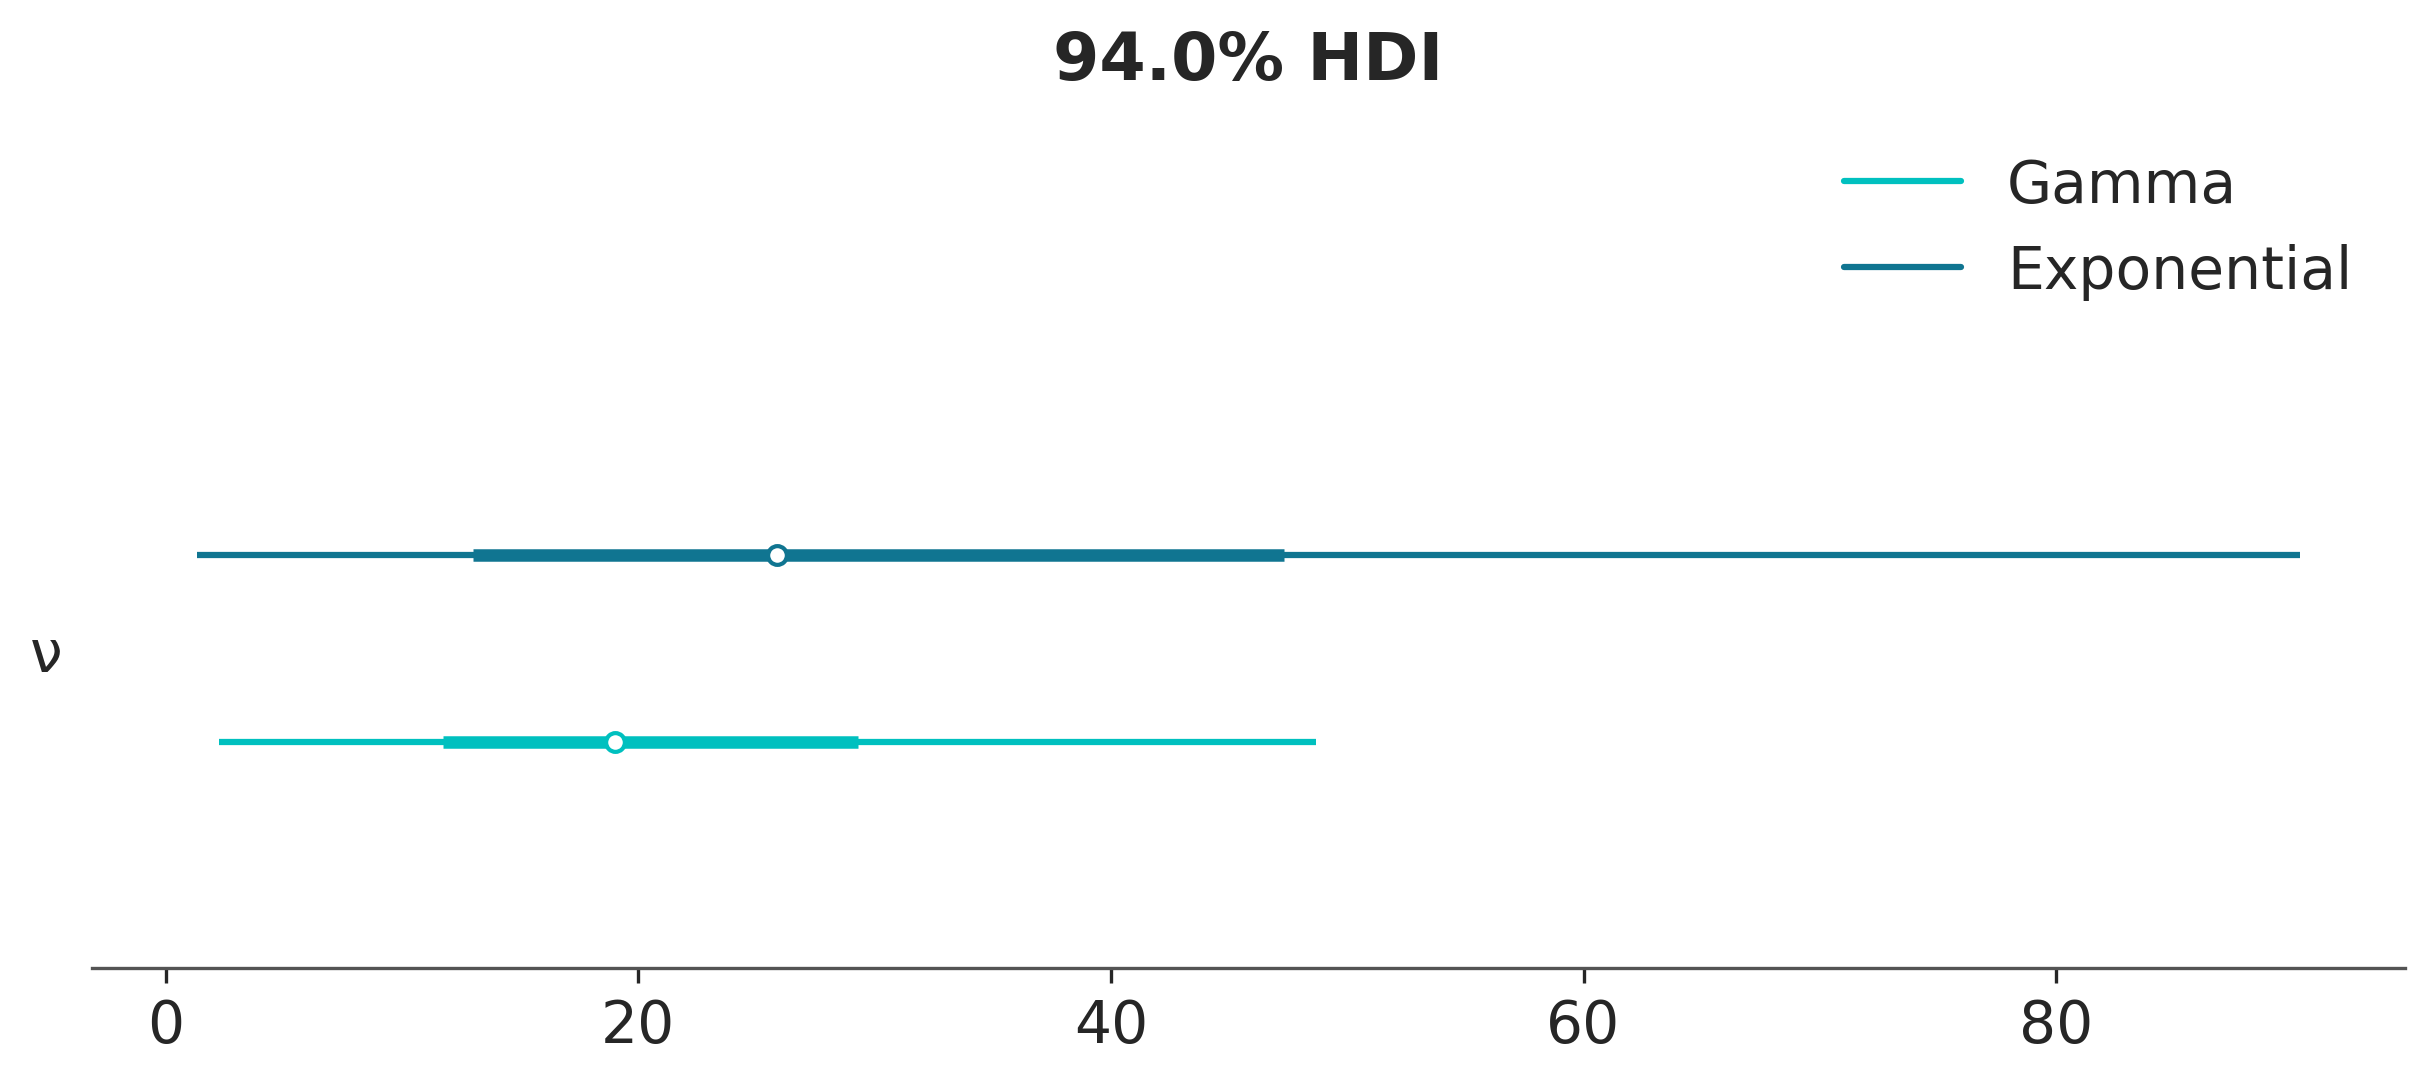

In [25]:
az.plot_forest([idata_t2_exp, idata_t2_gamma], model_names=["Exponential", "Gamma"], var_names=["ν"], figsize=(8, 3.5), combined=True);

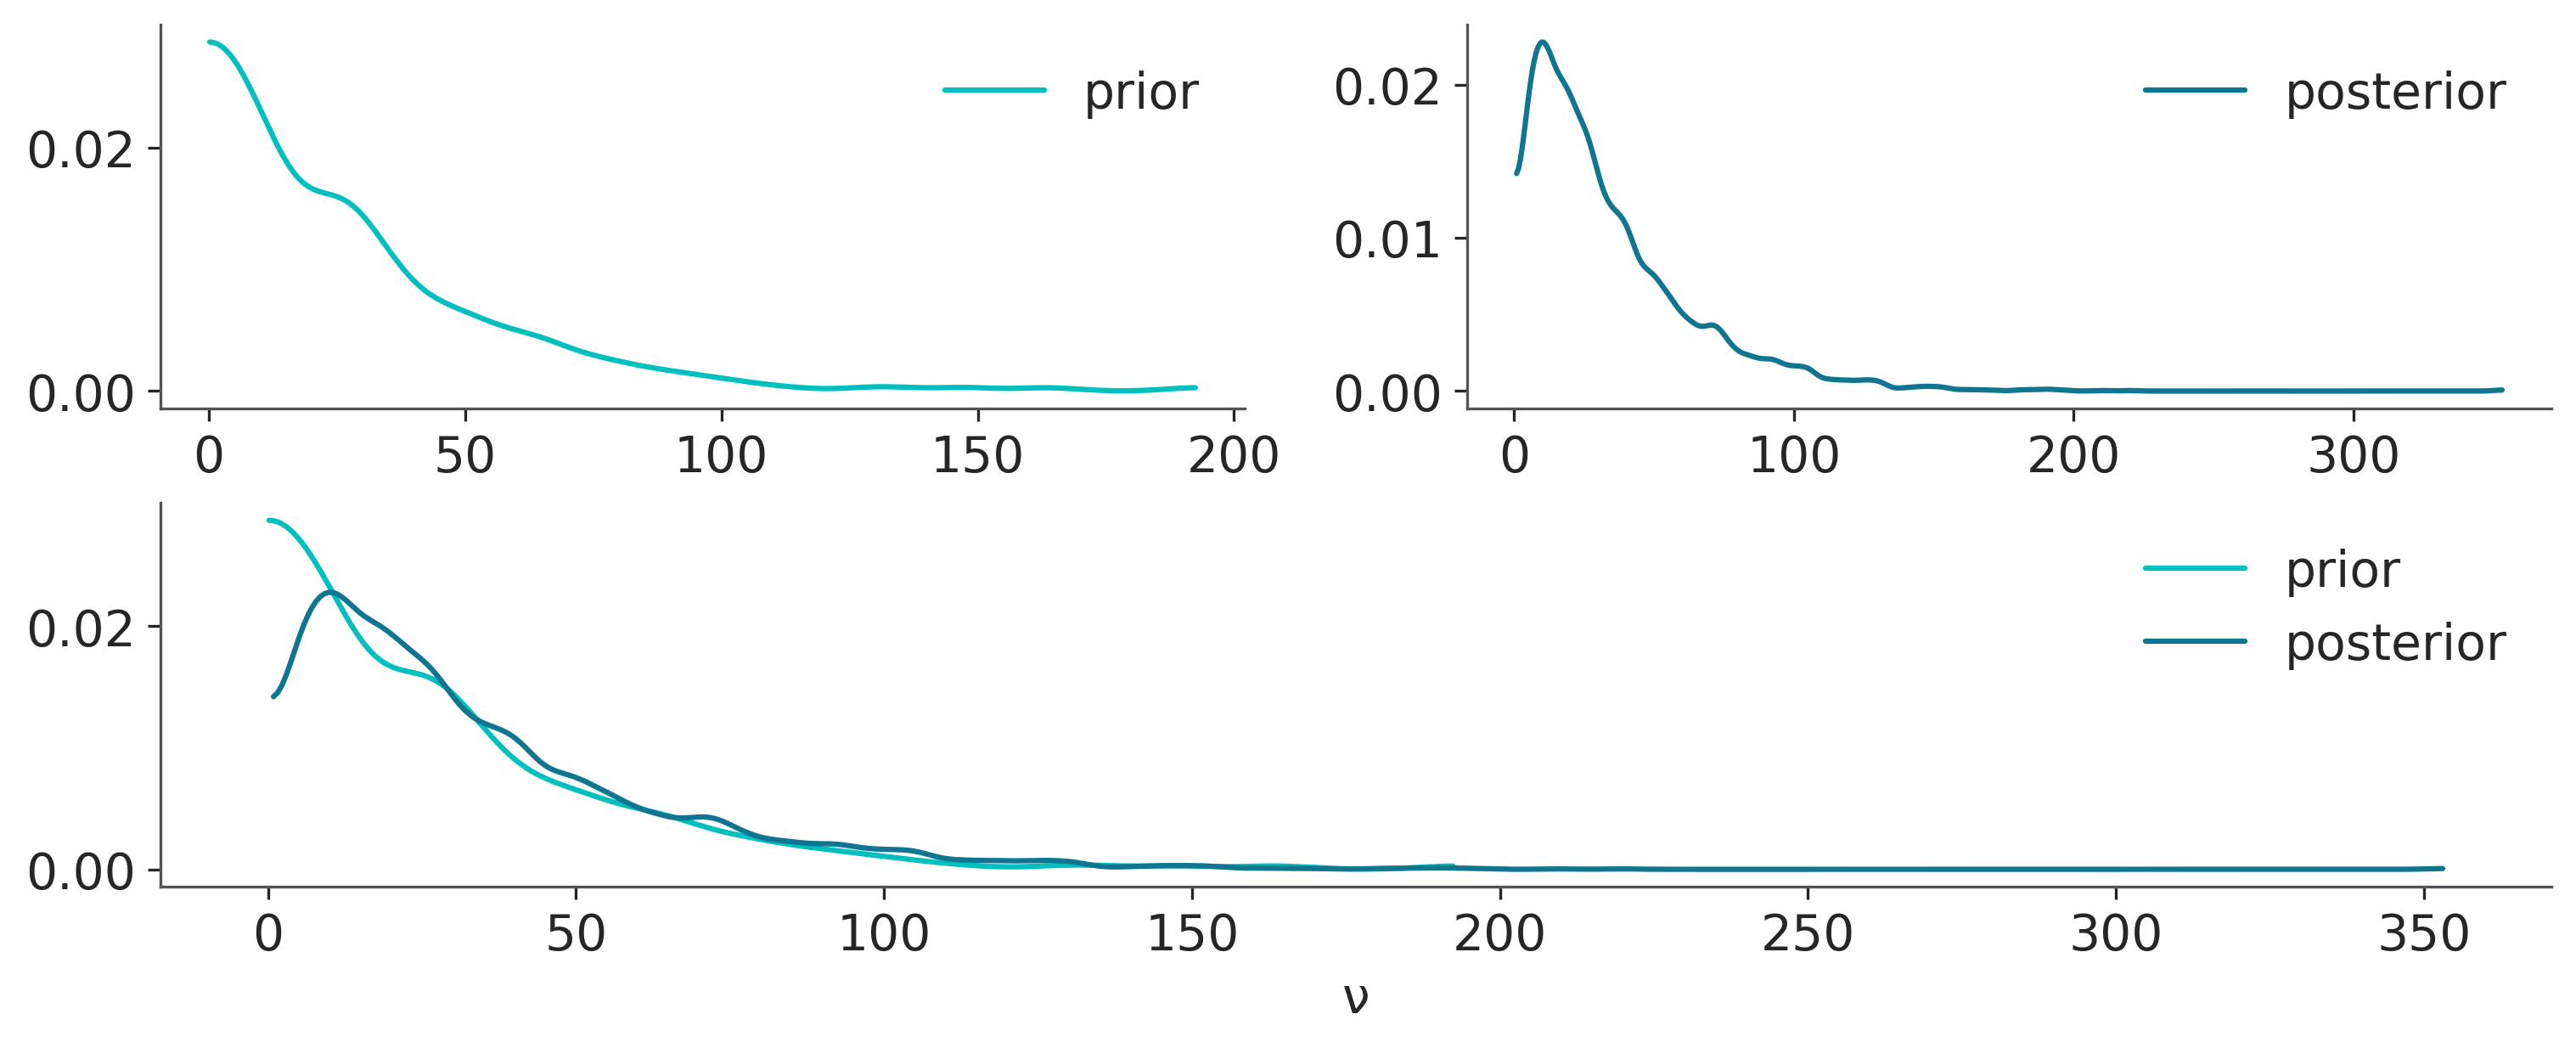

In [26]:
az.plot_dist_comparison(idata_t2_exp, var_names=["ν"], figsize=(10, 4));

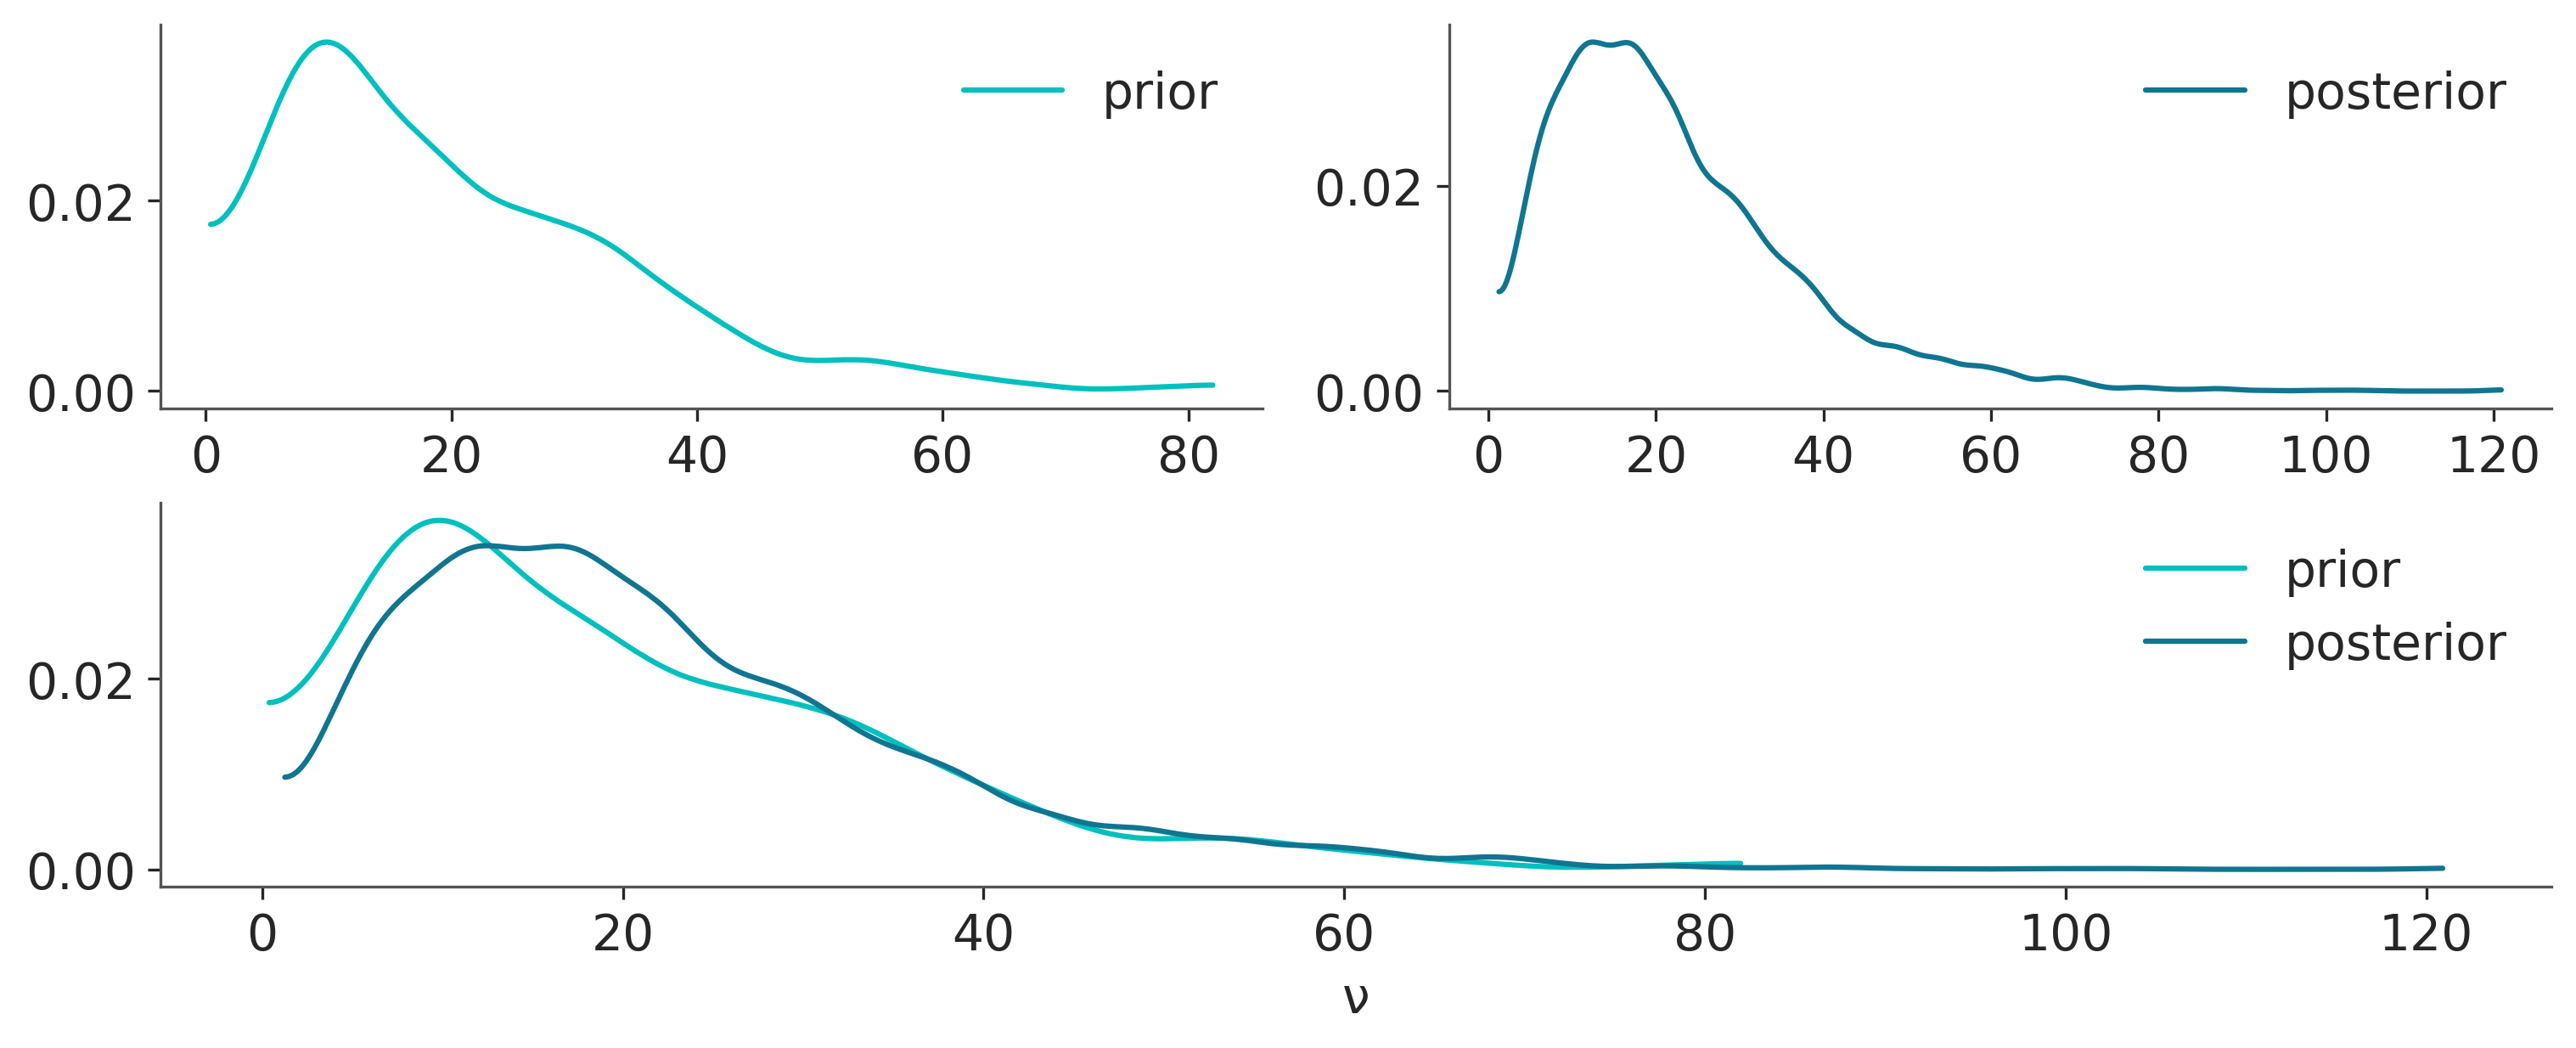

In [27]:
az.plot_dist_comparison(idata_t2_gamma, var_names=["ν"], figsize=(10, 4));

## Exercise 6
***

*Rerun model_lrs using the petal_length variable and then the petal_width variable. What are the main differences in the results? How wide or narrow is the 94% HDI in each case?*

In [28]:
iris = pd.read_csv('../code/data/iris.csv')
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes

var_names = ['α', 'β', 'bd']

In [29]:
for feature in ["sepal_length", "petal_width", "petal_length"]:

    x_n = feature
    x_0 = df[x_n].values
    x_c = x_0 - x_0.mean()

    with pm.Model() as model_0:
        α = pm.Normal('α', mu=0, sigma=10)
        β = pm.Normal('β', mu=0, sigma=10)

        μ = α + pm.math.dot(x_c, β)    
        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -α/β)

        yl = pm.Bernoulli('yl', p=θ, observed=y_0)

        idata_0 = pm.sample()
        
        print("Feature {} summary".format(feature))
        print(az.summary(idata_0, var_names=var_names))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Feature sepal_length summary
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.302  0.330  -0.315    0.914      0.006    0.005    3141.0    2730.0   
β   5.360  1.020   3.556    7.356      0.017    0.013    3526.0    2408.0   
bd -0.056  0.062  -0.167    0.064      0.001    0.001    3145.0    2781.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 231 divergences after tuning. Increase `target_accept` or reparameterize.


Feature petal_width summary
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    0.700  1.787  -2.674    4.160      0.052    0.036    1198.0    1447.0   
β   18.223  5.435   8.871   28.377      0.166    0.121    1118.0    1355.0   
bd  -0.040  0.091  -0.205    0.125      0.002    0.002    1498.0    2080.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1259 divergences after tuning. Increase `target_accept` or reparameterize.


Feature petal_length summary
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    2.385  2.758  -2.650    7.611      0.101    0.089     743.0     617.0   
β   10.000  2.911   4.717   15.218      0.097    0.071     876.0     907.0   
bd  -0.254  0.275  -0.757    0.223      0.009    0.007     892.0     912.0   

    r_hat  
α    1.00  
β    1.01  
bd   1.00  


From the results, we can see that the `bd` variable's HPD is the smallest with sepal length, and increases with petal_width and petal_length.

## Exercise 7
***

*Repeat previous exercise, this time using a Student's t-distribution as a weakly informative prior. Try different values of $\nu$

In [30]:
for nu in [1, 10, 30]:

    x_0 = df["petal_length"].values
    x_c = x_0 - x_0.mean()

    with pm.Model() as model_0:
        # Priors have been changed
        α = pm.StudentT('α', nu=nu, mu=0, sigma=10)
        β = pm.StudentT('β', nu=nu, mu=0, sigma=10)


        μ = α + pm.math.dot(x_c, β)    
        θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
        bd = pm.Deterministic('bd', -α/β)

        yl = pm.Bernoulli('yl', p=θ, observed=y_0)

        idata_0 = pm.sample()
        
        print(f"Feature {feature} nu {nu} summary")
        print(az.summary(idata_0, var_names=var_names))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1357 divergences after tuning. Increase `target_accept` or reparameterize.


Feature petal_length nu 1 summary
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    2.281  2.819  -2.462    8.154      0.100    0.080     803.0     776.0   
β   10.093  3.061   4.522   15.514      0.112    0.082     730.0     802.0   
bd  -0.243  0.277  -0.762    0.230      0.009    0.007     941.0    1015.0   

    r_hat  
α    1.01  
β    1.00  
bd   1.00  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1451 divergences after tuning. Increase `target_accept` or reparameterize.


Feature petal_length nu 10 summary
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    2.449  2.906  -2.562    8.187      0.120    0.086     575.0     676.0   
β   10.197  3.021   5.136   16.087      0.106    0.078     797.0     884.0   
bd  -0.256  0.280  -0.778    0.214      0.011    0.008     654.0    1017.0   

    r_hat  
α    1.01  
β    1.00  
bd   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1288 divergences after tuning. Increase `target_accept` or reparameterize.


Feature petal_length nu 30 summary
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    2.474  2.870  -2.382    8.212      0.102    0.077     809.0     884.0   
β   10.054  2.932   4.824   15.416      0.109    0.078     721.0    1111.0   
bd  -0.259  0.282  -0.805    0.200      0.009    0.007     938.0    1255.0   

    r_hat  
α     1.0  
β     1.0  
bd    1.0  
